In [1]:
from vectorhash_imported import *
from vectorhash_convered import *
from nd_scaffold import GridScaffold
import math
from scipy.stats import norm


lambdas = [3,4,5]
shapes = [(i, i) for i in lambdas]
percent_nonzero_relu = 0.99
W_gh_var = 1
sparse_initialization = 0.1
T = 0.000000005
W_hg_std = math.sqrt(W_gh_var)
W_hg_mean = -W_hg_std * norm.ppf(1 - percent_nonzero_relu) / math.sqrt(len(lambdas))
h_normal_mean = len(lambdas) * W_hg_mean
h_normal_std = math.sqrt(len(lambdas)) * W_hg_std
relu_theta = math.sqrt((1 - sparse_initialization) * len(lambdas)) * norm.ppf(
    1 - percent_nonzero_relu
)
num_imgs = 201

print(percent_nonzero_relu, W_hg_mean, W_hg_std, h_normal_mean, h_normal_std, relu_theta)

GS = GridScaffold(
    shapes=shapes,
    N_h=1200,
    input_size=784,
    h_normal_mean=h_normal_mean,
    h_normal_std=h_normal_std,
    device=None,
    sparse_matrix_initializer=SparseMatrixBySparsityInitializer(
        sparsity=sparse_initialization, device="cpu"
    ),
    relu_theta=relu_theta, ######
    from_checkpoint=False,
    T=T,
    continualupdate=False,
    ratshift=False,
    initialize_W_gh_with_zeroes=False,
    pseudo_inverse=False,
    batch_update=False,
    use_h_fix=False,
    learned_pseudo=False,
    epsilon=0.01,
    calculate_update_scaling_method="norm",
    MagicMath=False,
    sanity_check=False,
    calculate_g_method="fast",
)

0.99 1.3431175713061931 1.0 4.02935271391858 1.7320508075688772 -3.822579621649066
UPDATE SCALING BY SCHWARZ ERROR True
module shapes:  [(3, 3), (4, 4), (5, 5)]
N_g     :  50
N_patts :  3600
N_h     :  1200


In [2]:
def prepare_data(
    dataset,
    num_imgs=5,
    preprocess_sensory=True,
    noise_level="medium",
    use_fix=False,
):
    import torch
    import random

    data = dataset.train_data.flatten(1)[:num_imgs].float().to("cpu")
    # data = random.sample(dataset.data.flatten(1).float().to("cpu"), num_imgs)
    if preprocess_sensory:
        if use_fix:
            for i in range(len(data)):
                data[i] = (data[i] - data[i].mean()) / data[i].std()

        # data = (data - data.mean(dim=0)) / (data.std(dim=0) + 1e-8)
    # noissing the data
        data = data / 255.0
    if noise_level == "none":
        return data, data
    elif noise_level == "low":
        random_noise = torch.zeros_like(data).uniform_(-1, 1)
    elif noise_level == "medium":
        random_noise = torch.zeros_like(data).uniform_(-1.25, 1.25)
    elif noise_level == "high":
        random_noise = torch.zeros_like(data).uniform_(-1.5, 1.5)
    noisy_data = data + random_noise

    return data, noisy_data

def prepare_data_random(noise_scale=0.1):
    data = torch.randn((num_imgs, 784))
    noise = noise_scale * torch.randn((num_imgs, 784))
    return data, data + noise

/Users/Ile-Maurice/Desktop/rl-research-main/rl-research/.conda/lib/python3.12/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


0.01 -1.3431175713061931 1.0 -4.02935271391858 1.7320508075688772 1.8019813147290409
UPDATE SCALING BY SCHWARZ ERROR True
module shapes:  [(3, 3), (4, 4), (5, 5)]
N_g     :  50
N_patts :  3600
N_h     :  1700


201it [00:00, 213.55it/s]


Unique Gs seen while learning: 201
Unique Hs seen while learning: 201
Unique Hs seen while recalling: 0
Unique Gs seen while recalling (right after learning): 0
Unique Gs seen while recalling (right after learning, after denoising): 0
Unique Gs seen while learning (after denoising): 201
Unique Hs seen while recalling: 201
Unique Gs seen while recalling (before denoising): 201
Unique Gs seen while recalling (after denoising): 66
Unique Hs seen while recalling (after denoising): 66
avg nonzero H: 150.37811279296875
avg nonzero H_denoised: 43.91044616699219
tensor(0.5396)


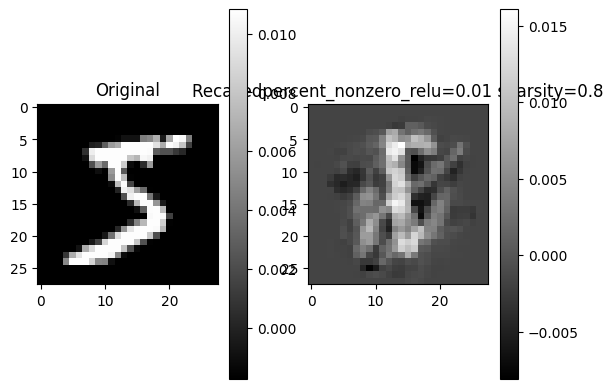

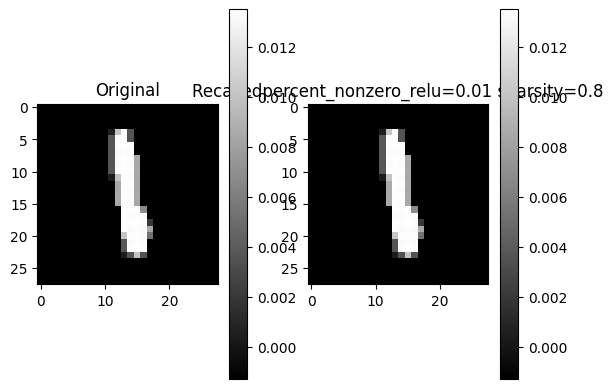

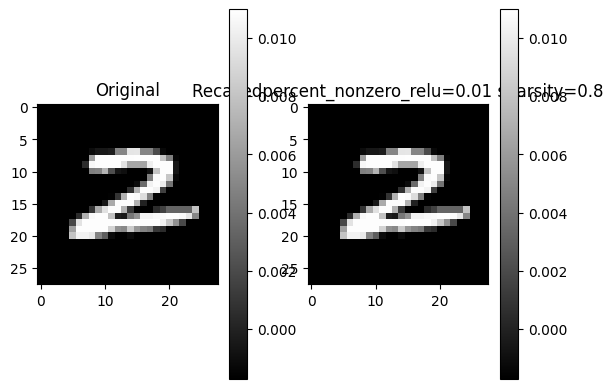

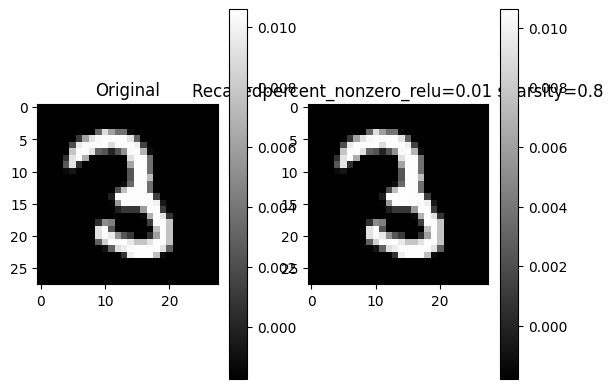

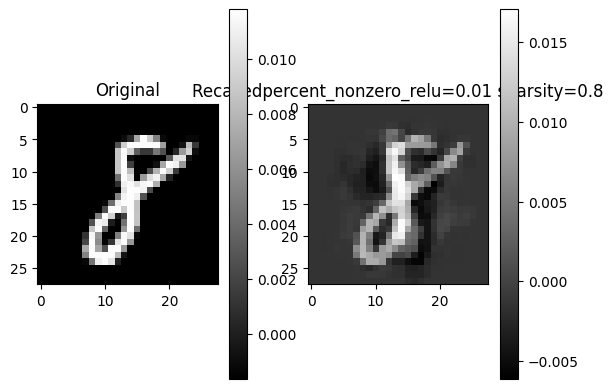

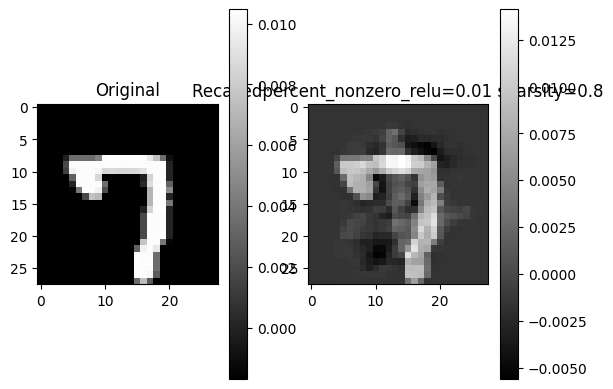

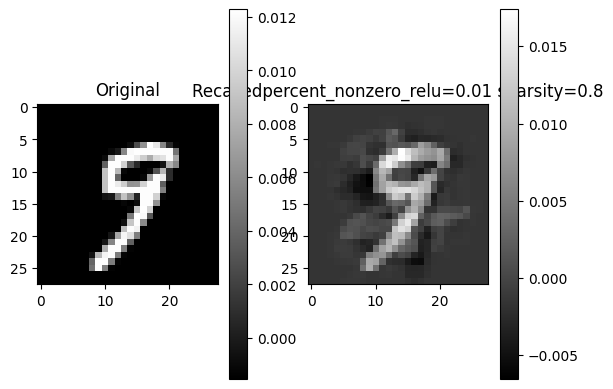

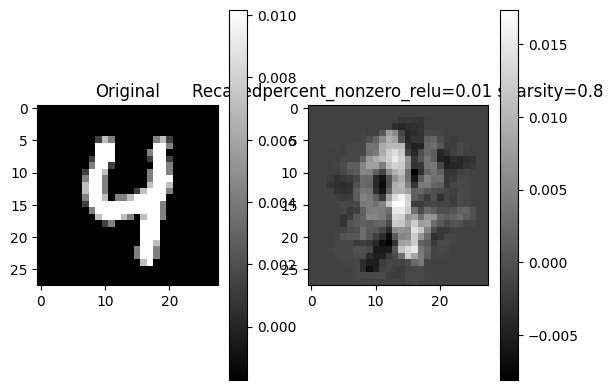

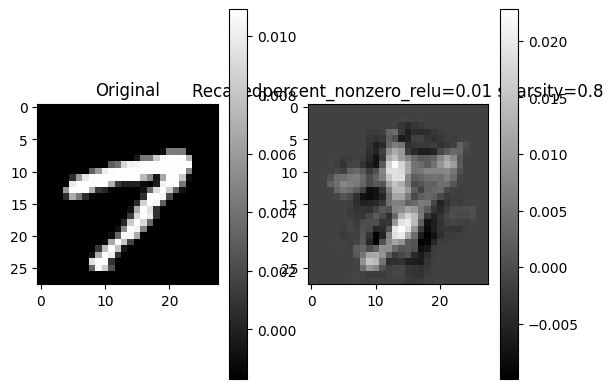

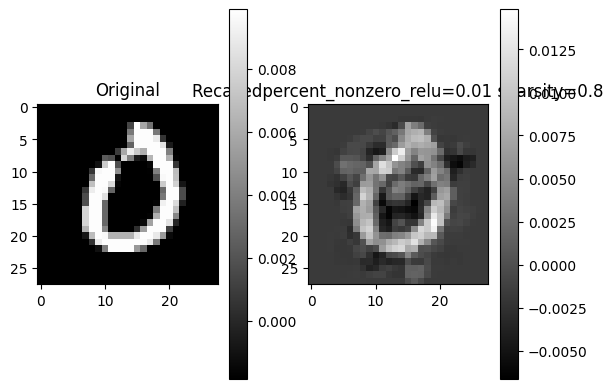

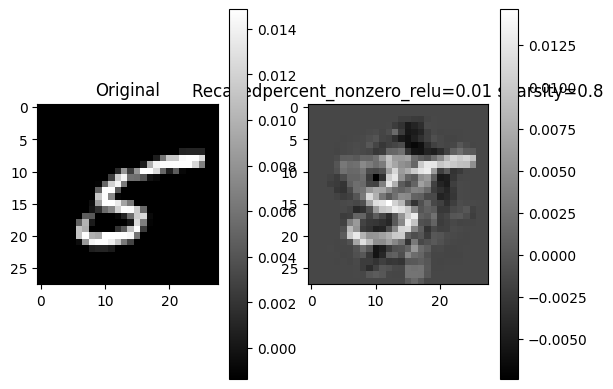

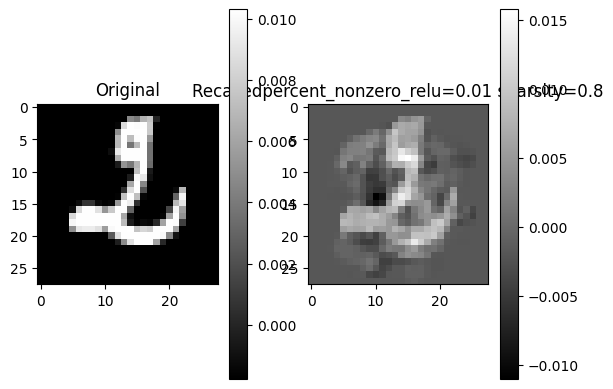

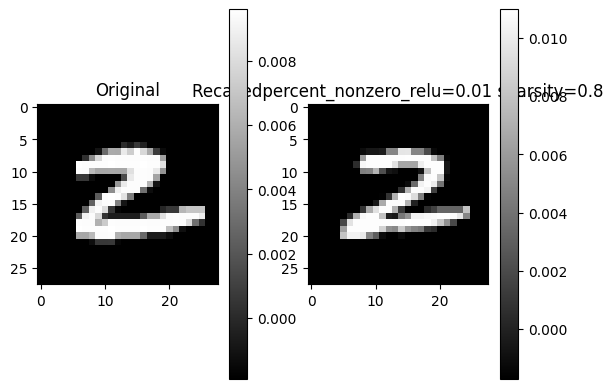

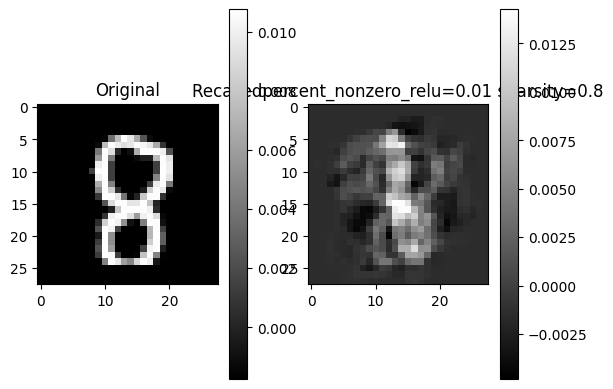

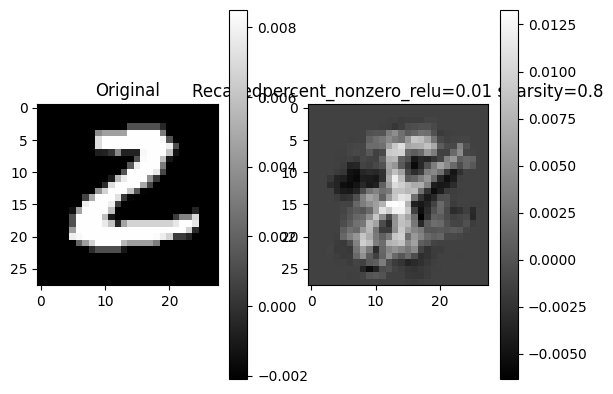

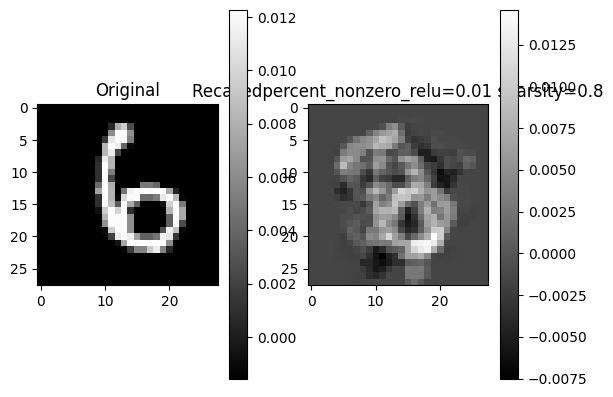

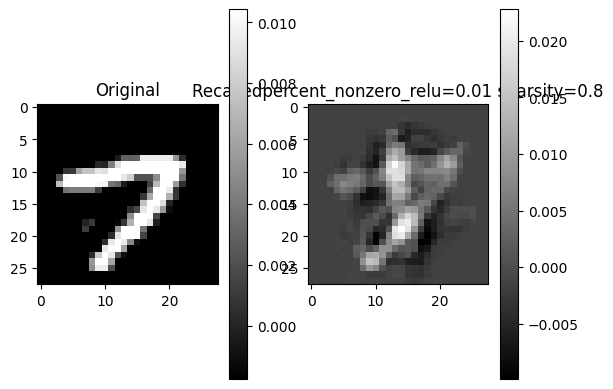

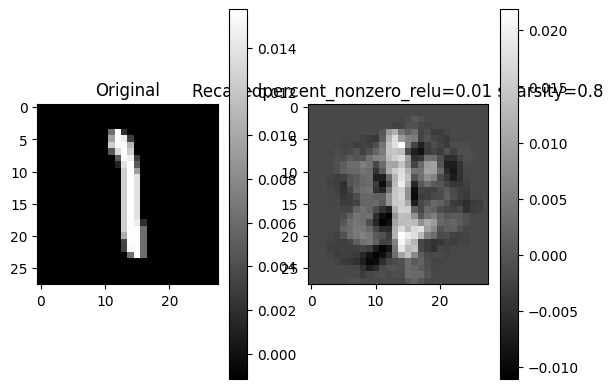

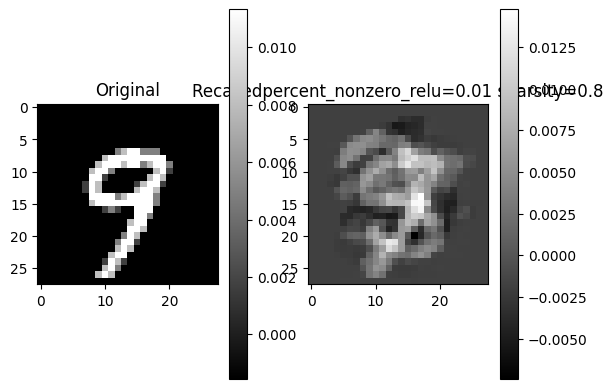

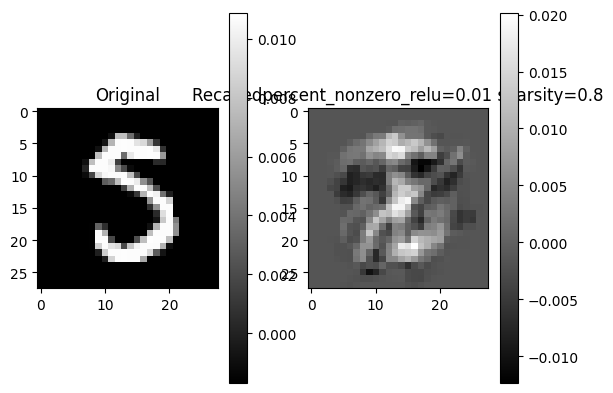

0.02 -1.1857324864011836 1.0 -3.5571974592035507 1.7320508075688772 1.5908270656337344
UPDATE SCALING BY SCHWARZ ERROR True
module shapes:  [(3, 3), (4, 4), (5, 5)]
N_g     :  50
N_patts :  3600
N_h     :  1700


201it [00:00, 207.76it/s]


Unique Gs seen while learning: 201
Unique Hs seen while learning: 201
Unique Hs seen while recalling: 0
Unique Gs seen while recalling (right after learning): 0
Unique Gs seen while recalling (right after learning, after denoising): 0
Unique Gs seen while learning (after denoising): 201
Unique Hs seen while recalling: 201
Unique Gs seen while recalling (before denoising): 201
Unique Gs seen while recalling (after denoising): 60
Unique Hs seen while recalling (after denoising): 60
avg nonzero H: 206.55224609375
avg nonzero H_denoised: 59.89552307128906
tensor(0.5117)


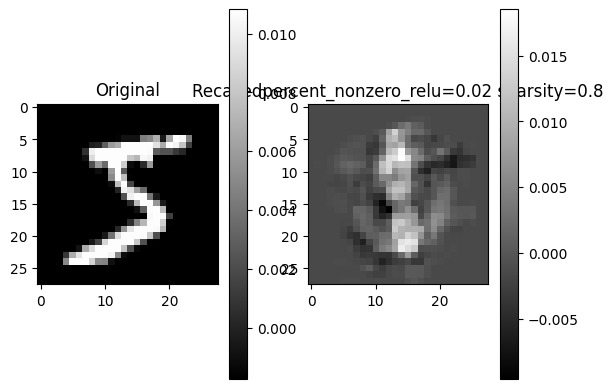

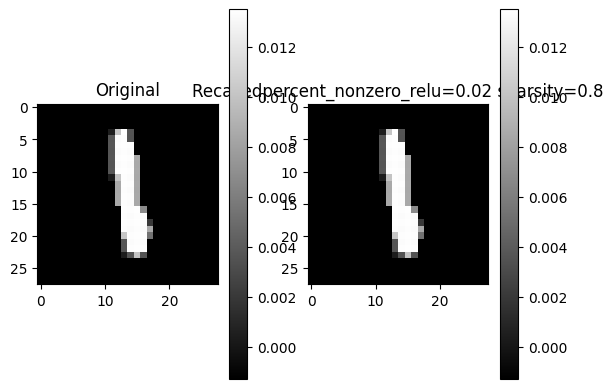

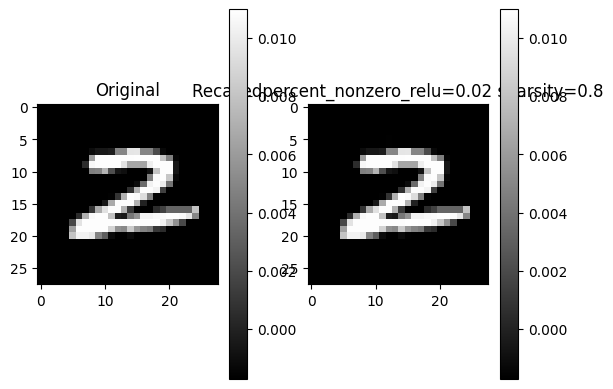

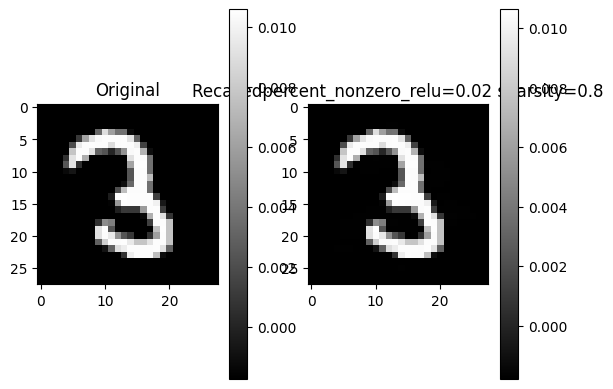

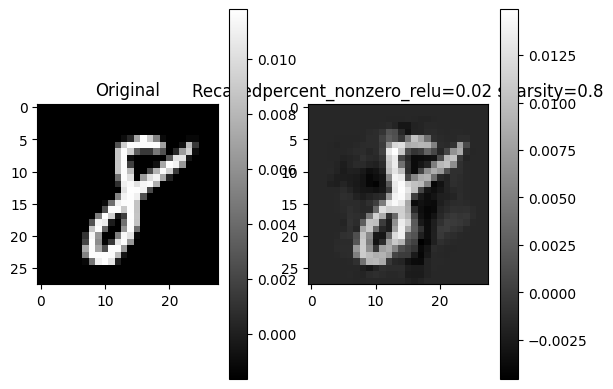

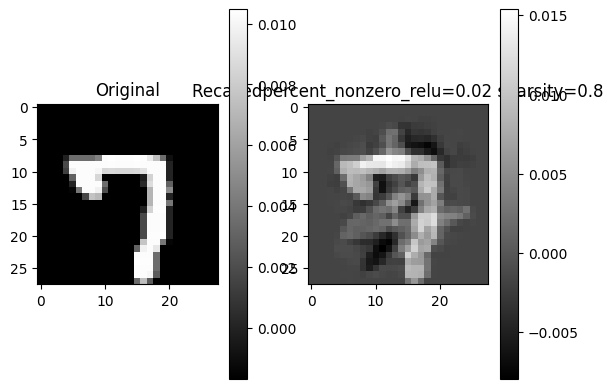

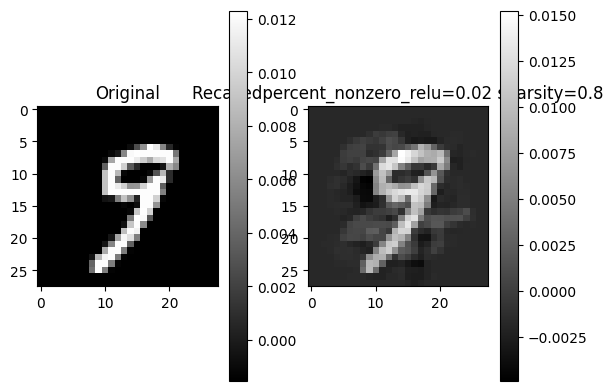

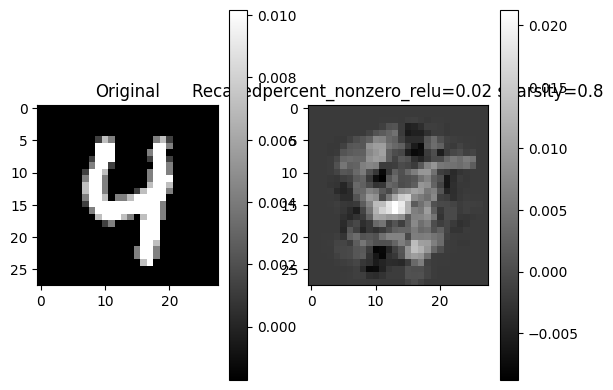

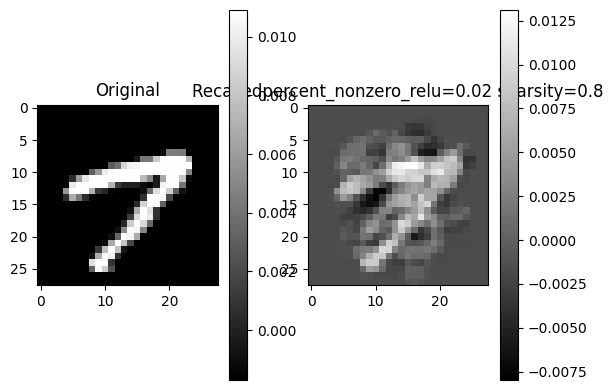

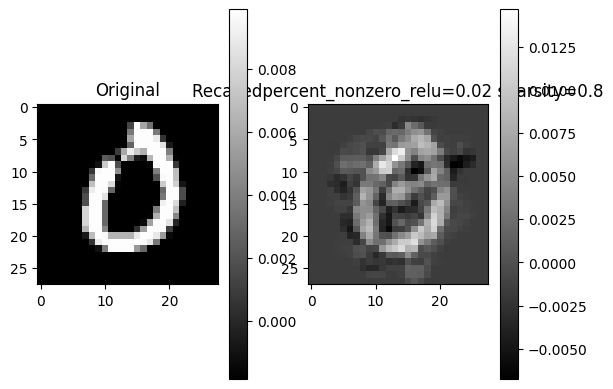

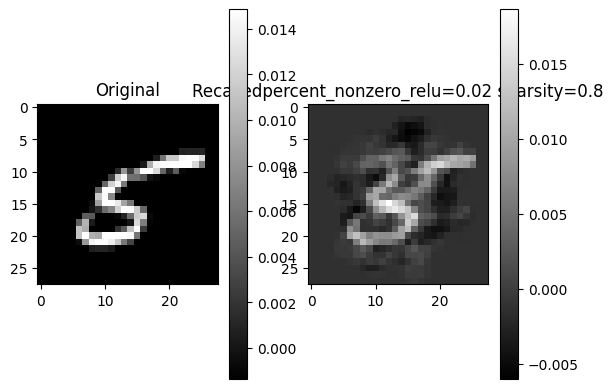

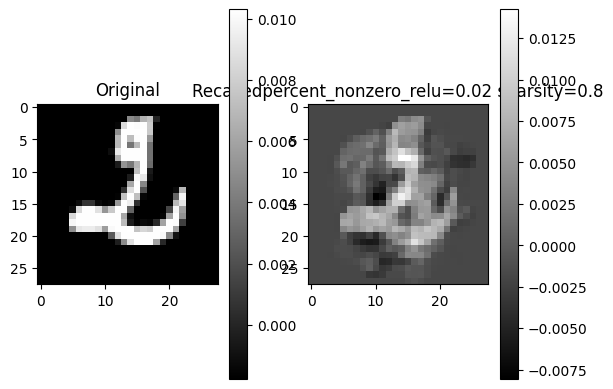

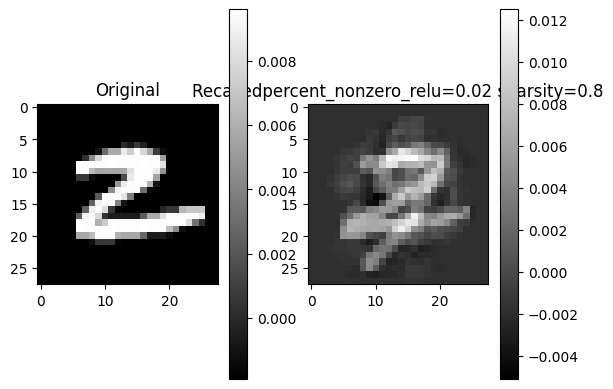

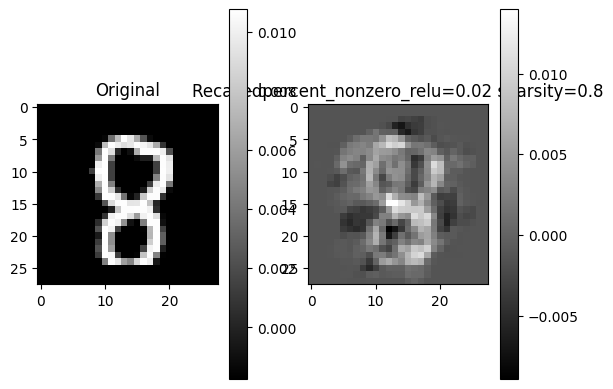

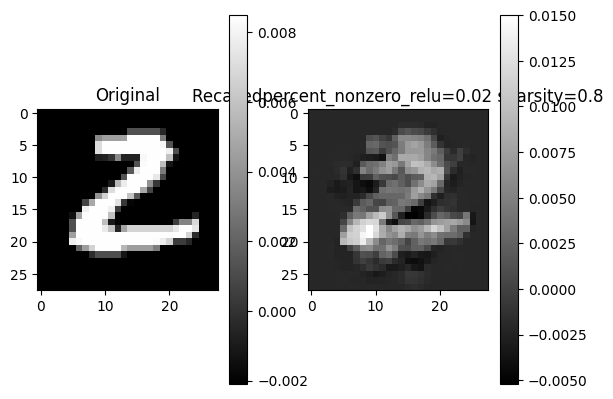

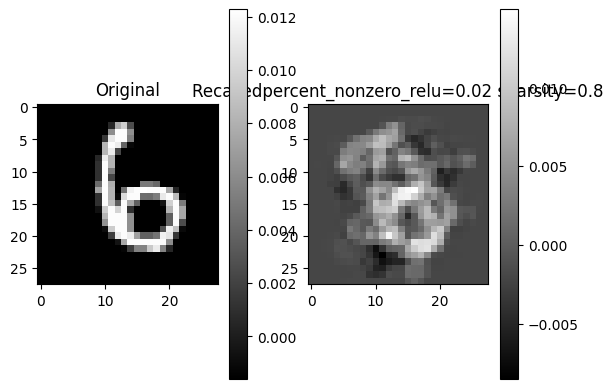

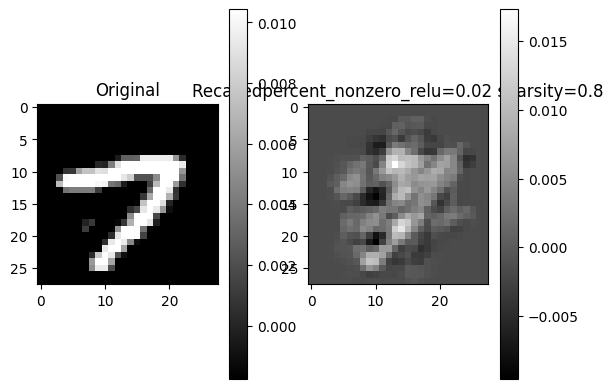

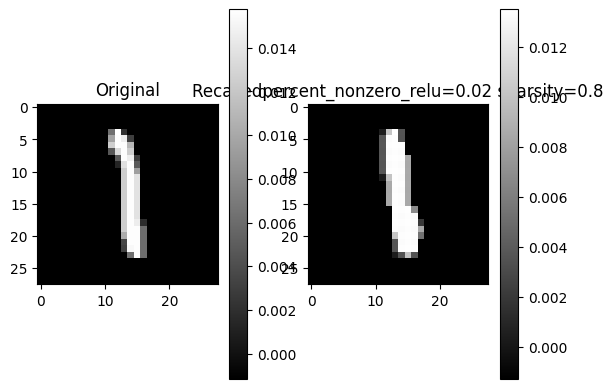

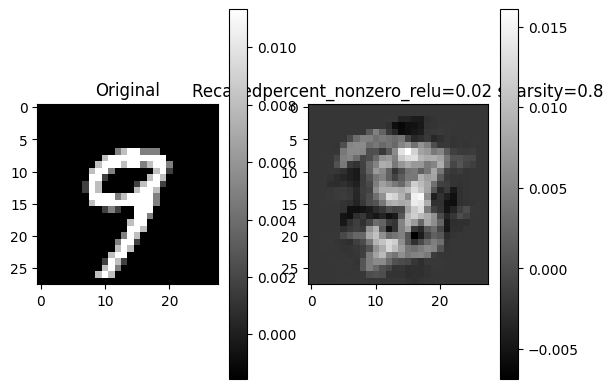

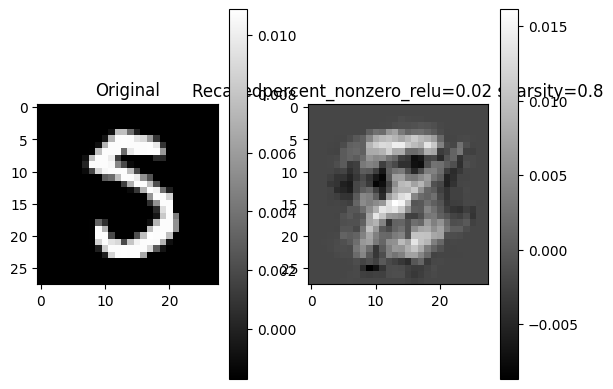

0.03 -1.085876695956252 1.0 -3.257630087868756 1.7320508075688772 1.4568564644046302
UPDATE SCALING BY SCHWARZ ERROR True
module shapes:  [(3, 3), (4, 4), (5, 5)]
N_g     :  50
N_patts :  3600
N_h     :  1700


201it [00:00, 210.26it/s]


Unique Gs seen while learning: 201
Unique Hs seen while learning: 201
Unique Hs seen while recalling: 0
Unique Gs seen while recalling (right after learning): 0
Unique Gs seen while recalling (right after learning, after denoising): 0
Unique Gs seen while learning (after denoising): 201
Unique Hs seen while recalling: 201
Unique Gs seen while recalling (before denoising): 201
Unique Gs seen while recalling (after denoising): 58
Unique Hs seen while recalling (after denoising): 58
avg nonzero H: 248.07960510253906
avg nonzero H_denoised: 78.2487564086914
tensor(0.5257)


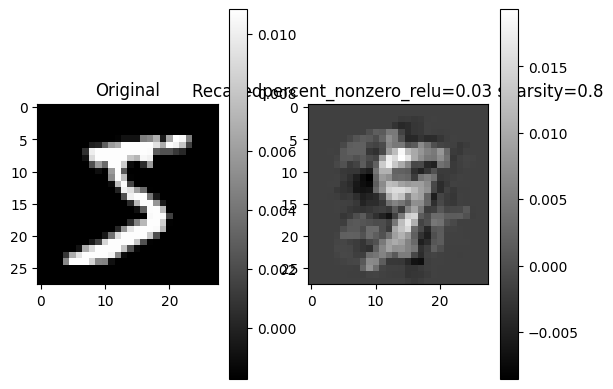

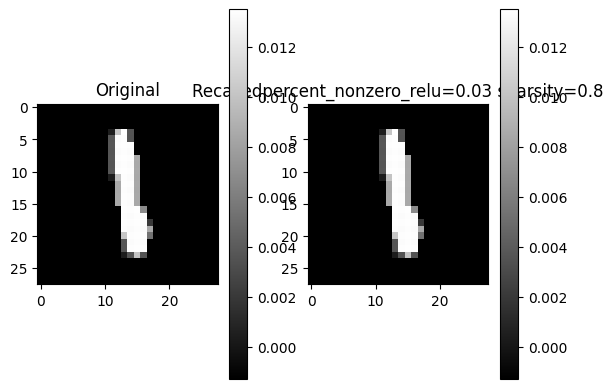

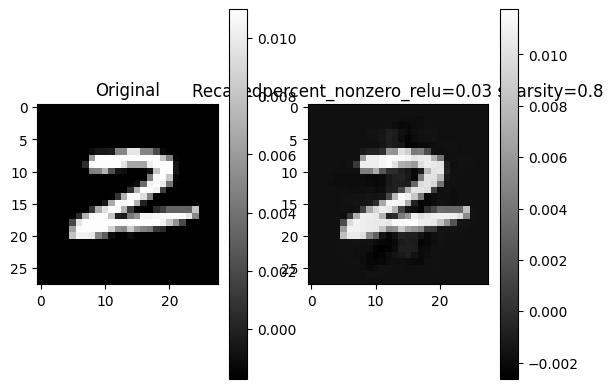

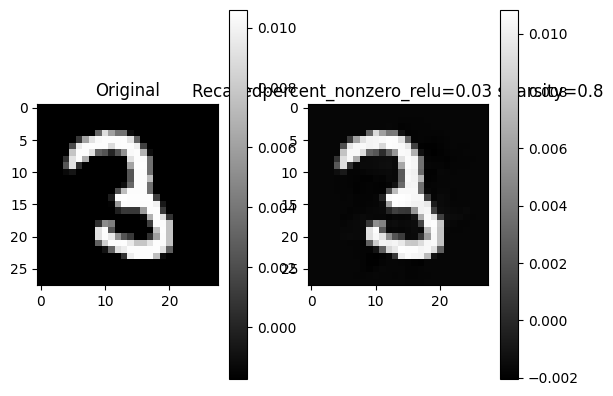

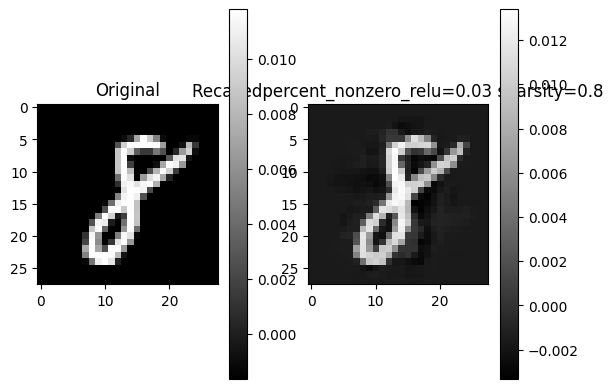

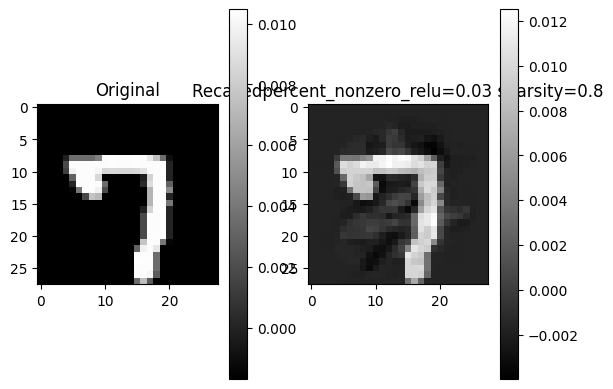

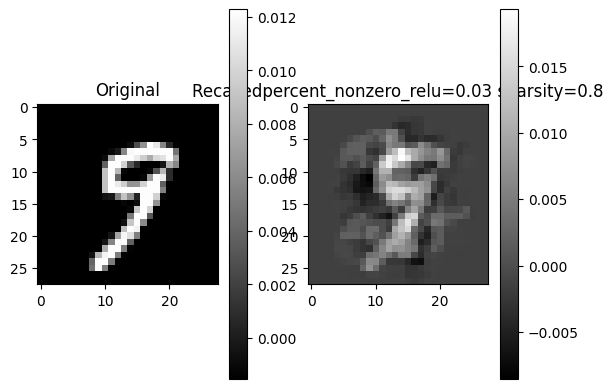

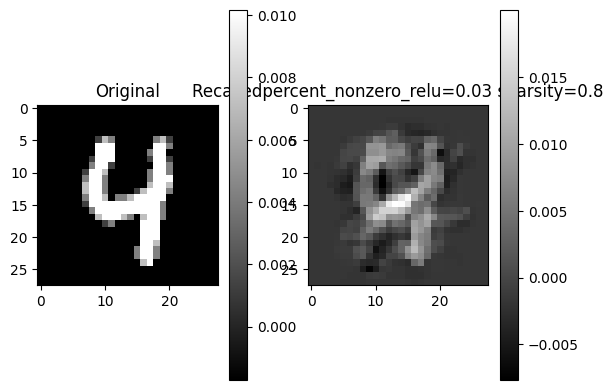

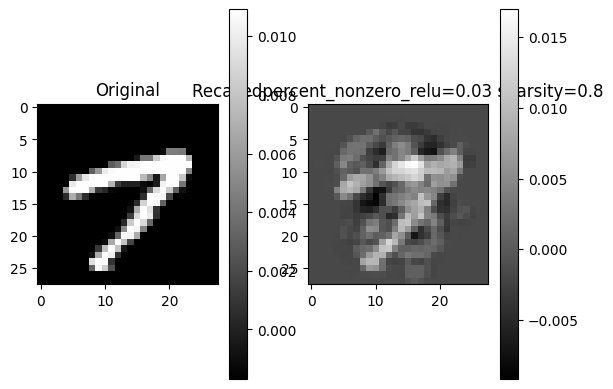

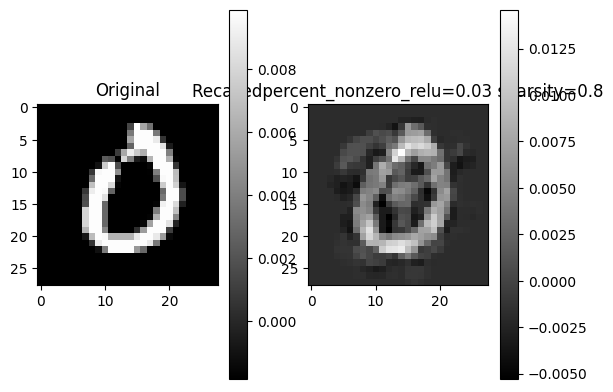

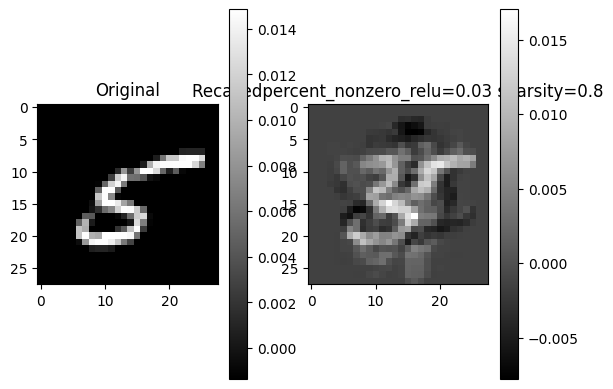

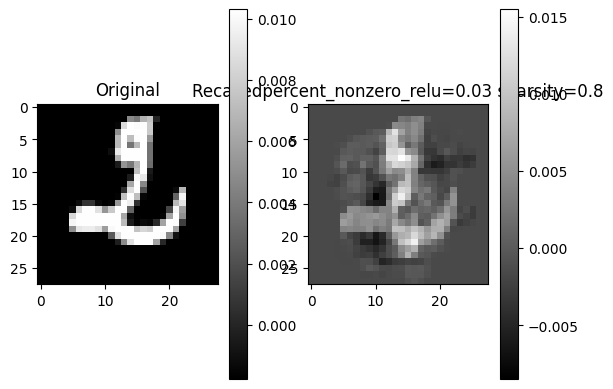

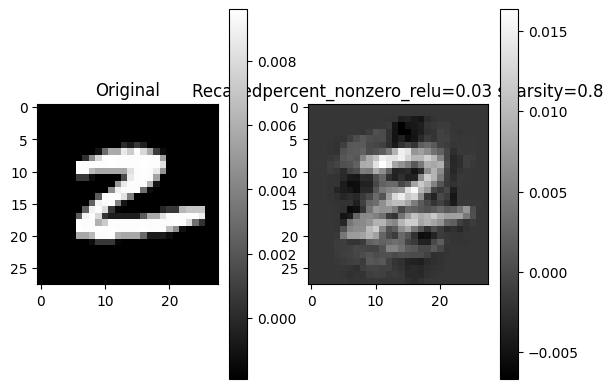

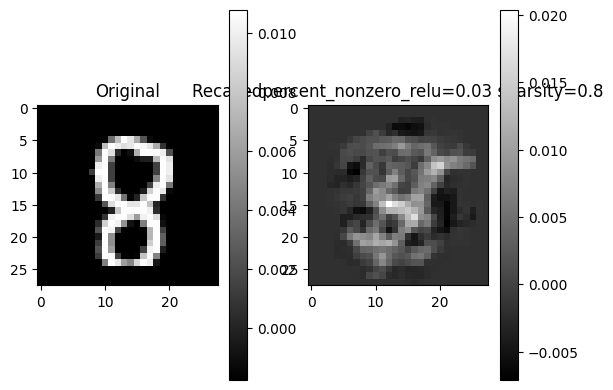

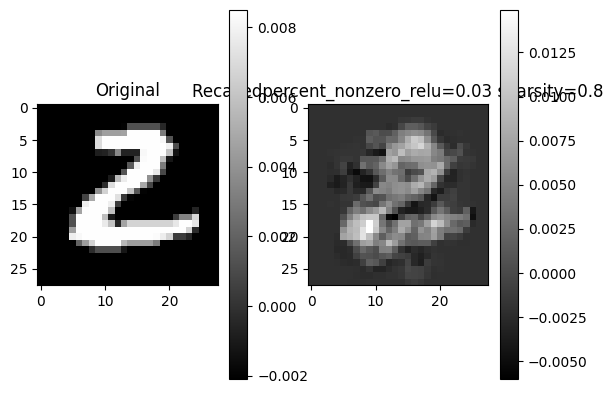

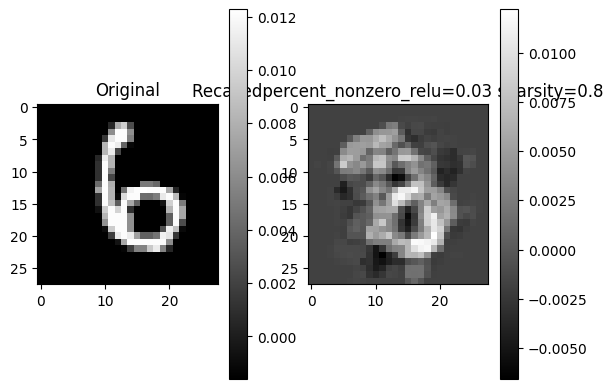

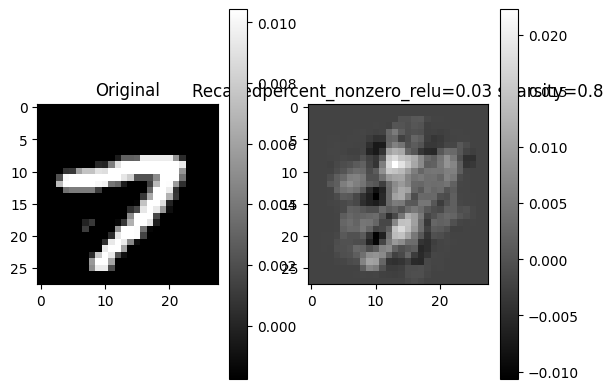

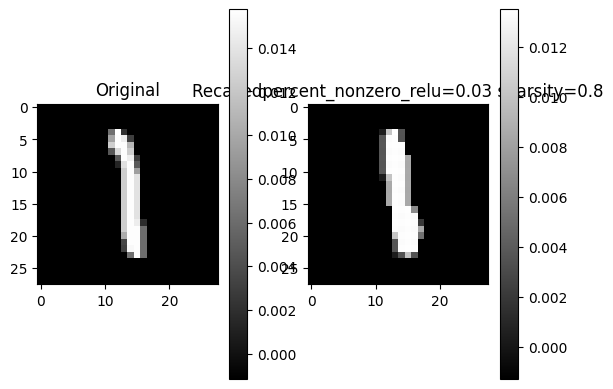

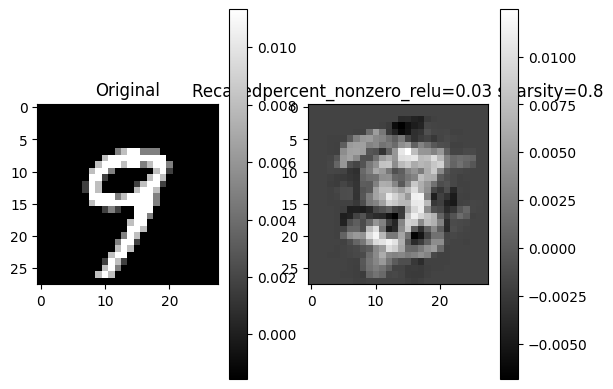

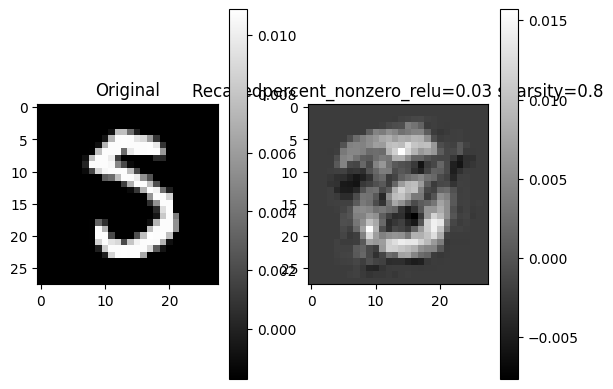

/Users/Ile-Maurice/Desktop/rl-research-main/rl-research/.conda/lib/python3.12/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


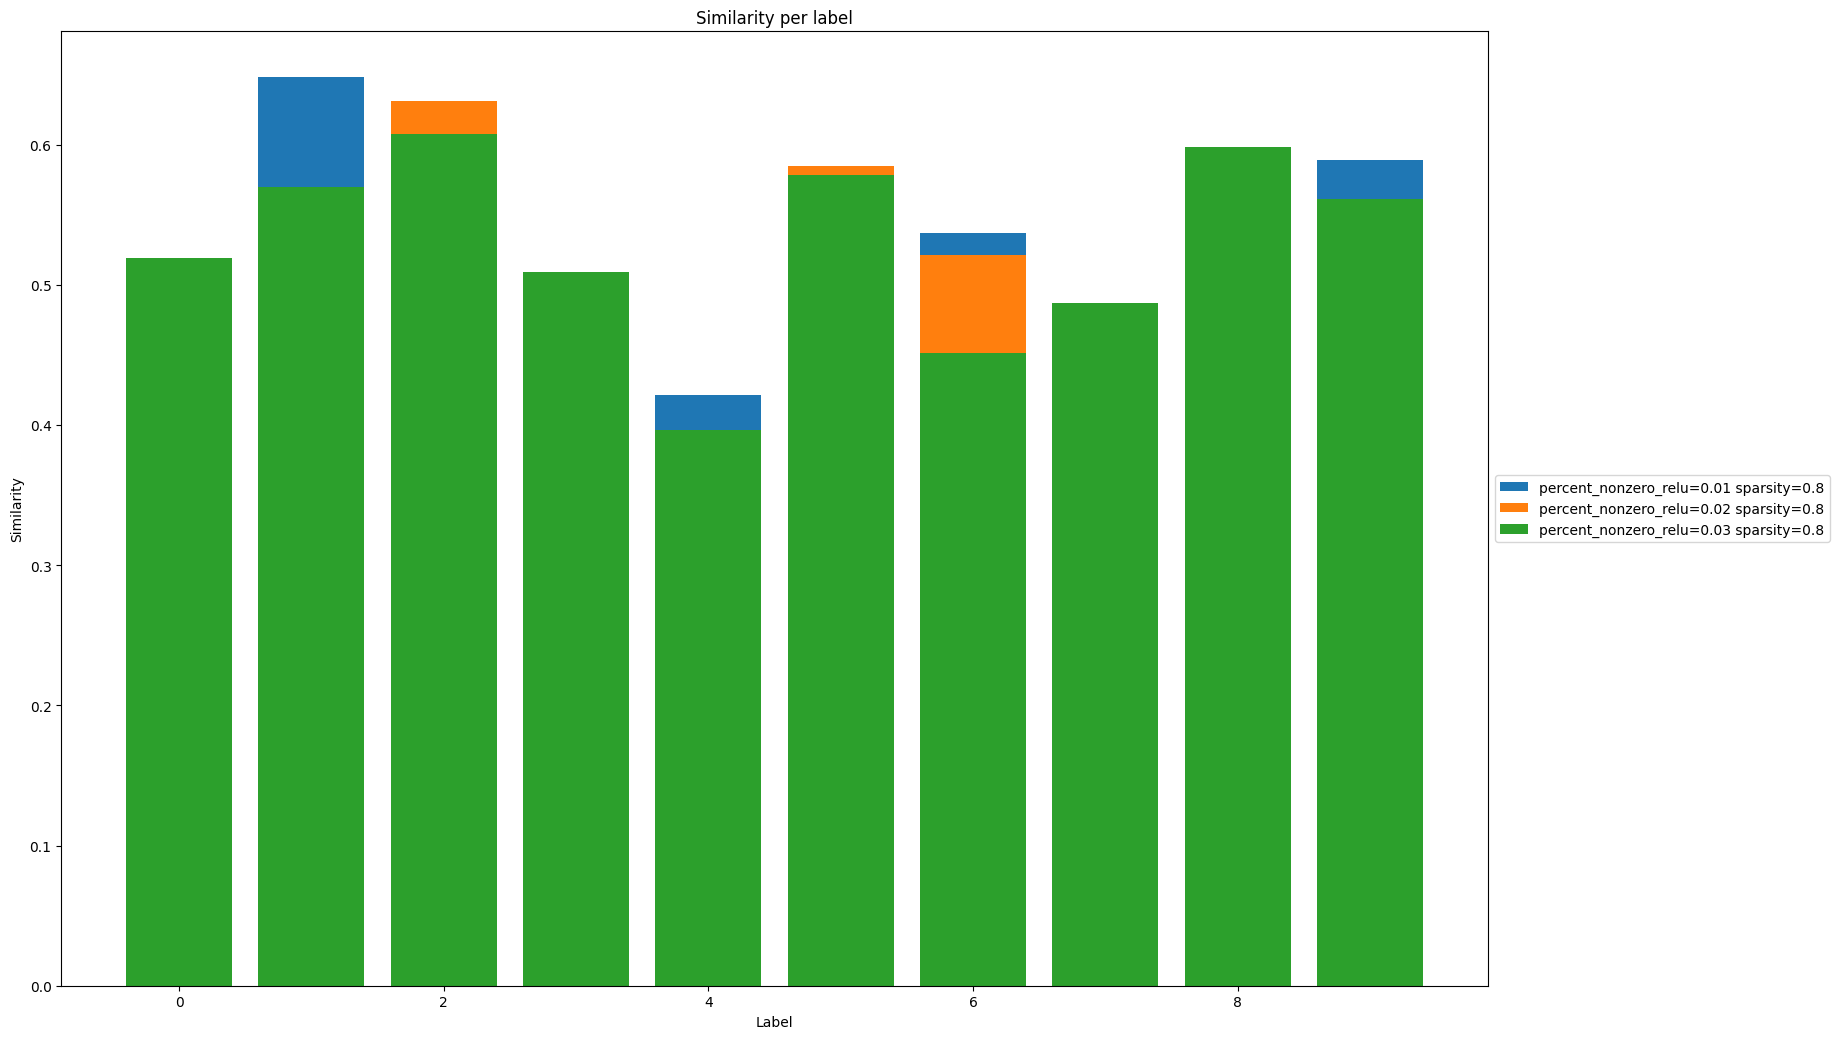

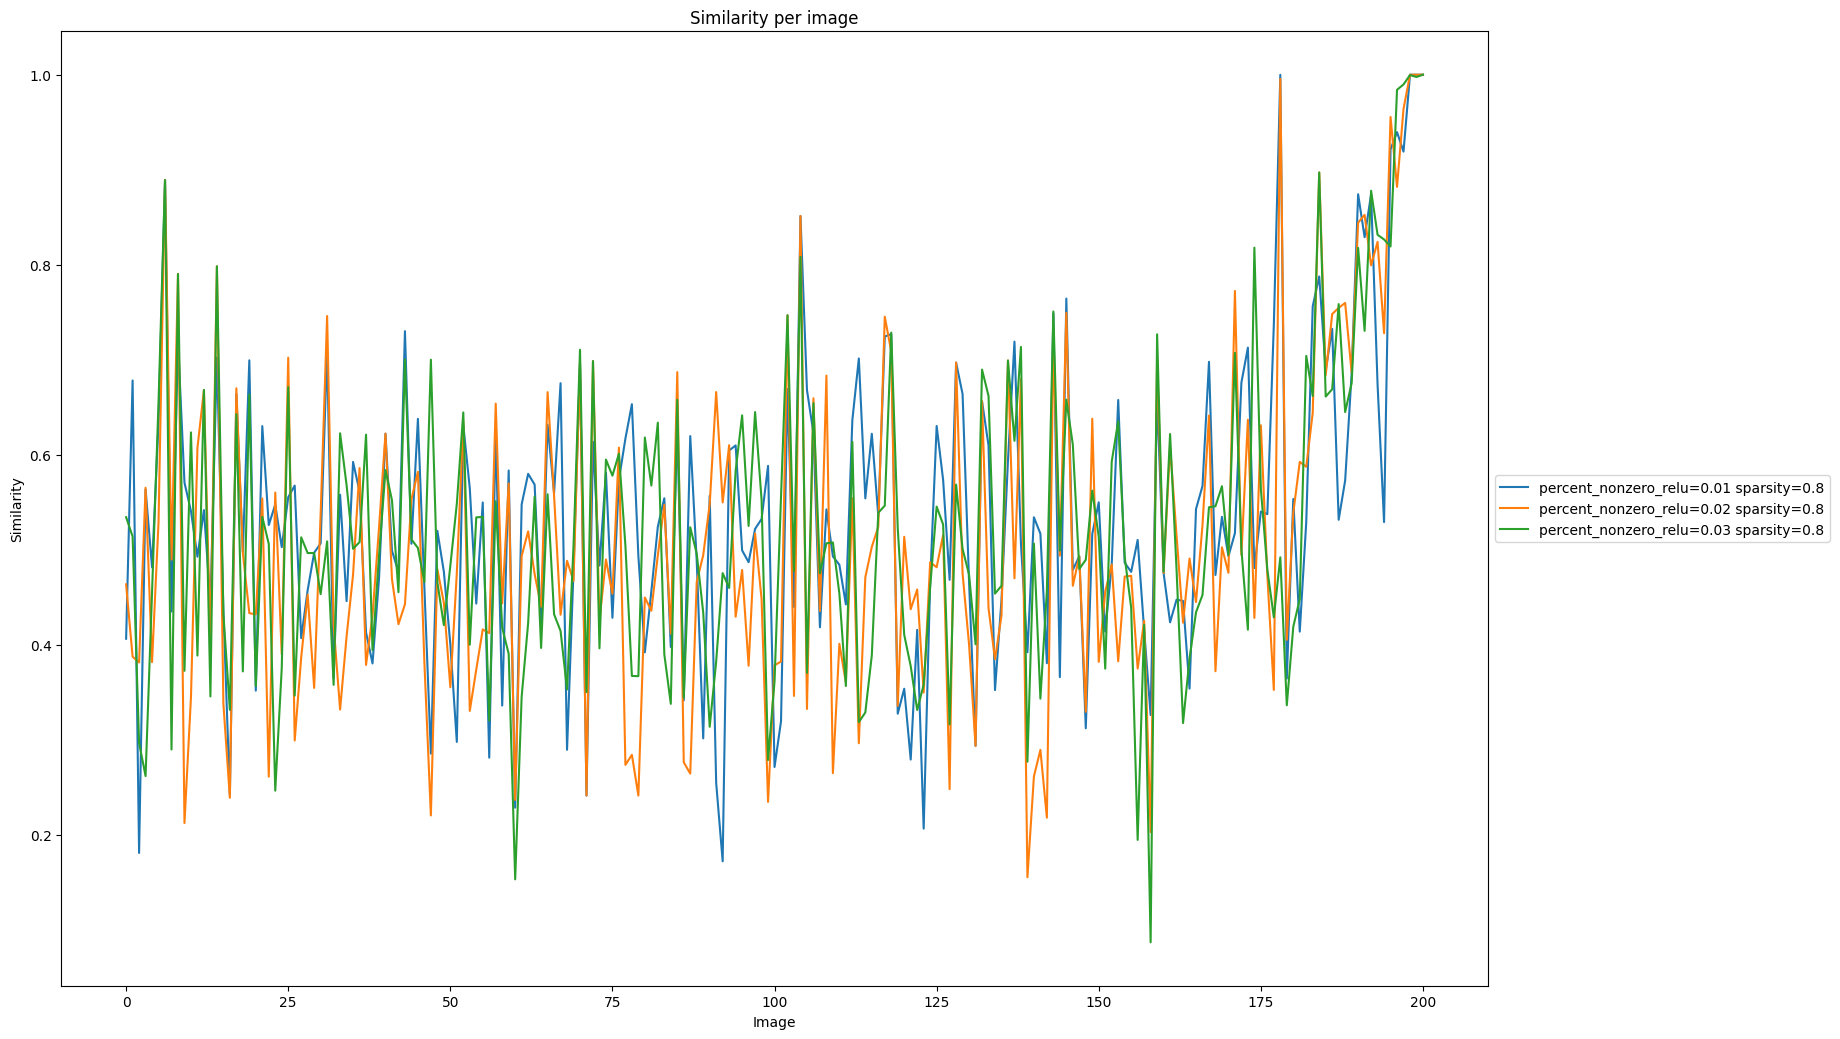

In [3]:
from vectorhash_functions import solve_mean, spacefillingcurve
import torchvision
from torchvision import transforms
import torch

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Lambda(lambda x: x.flatten())]
)

dataset = torchvision.datasets.MNIST(
    root="data", train=True, download=True, transform=transform
)

data, noisy_data = prepare_data(
    dataset,
    num_imgs=num_imgs,
    preprocess_sensory=True,
    noise_level="none",
    use_fix=True
)
# data, noisy_data = prepare_data_random(noise_scale=0) 
params = [[0.01, 0.8], [0.02, 0.8], [0.03, 0.8]]
sims = []
v = spacefillingcurve(shapes)

lambdas = [3,4,5]
shapes = [(i, i) for i in lambdas]
for i in params:
    percent_nonzero_relu = i[0]
    W_gh_var = 1
    sparse_initialization = i[1]
    T = 0.01
    W_hg_std = math.sqrt(W_gh_var)
    W_hg_mean = -W_hg_std * norm.ppf(1 - percent_nonzero_relu) / math.sqrt(len(lambdas))
    h_normal_mean = len(lambdas) * W_hg_mean
    h_normal_std = math.sqrt(len(lambdas)) * W_hg_std
    relu_theta = math.sqrt((1 - sparse_initialization) * len(lambdas)) * norm.ppf(
        1 - percent_nonzero_relu
    )
    num_imgs = 201

    print(percent_nonzero_relu, W_hg_mean, W_hg_std, h_normal_mean, h_normal_std, relu_theta)

    GS = GridScaffold(
        shapes=shapes,
        N_h=1700,
        input_size=784,
        h_normal_mean=h_normal_mean,
        h_normal_std=h_normal_std,
        device=None,
        sparse_matrix_initializer=SparseMatrixBySparsityInitializer(
            sparsity=sparse_initialization, device="cpu"
        ),
        relu_theta=relu_theta, ######
        from_checkpoint=False,
        T=T,
        continualupdate=False,
        ratshift=False,
        initialize_W_gh_with_zeroes=False,
        pseudo_inverse=False,
        batch_update=False,
        use_h_fix=False,
        learned_pseudo=False,
        epsilon=0.01,
        calculate_update_scaling_method="norm",
        MagicMath=False,
        sanity_check=False,
        calculate_g_method="fast",
        scaling_updates=True,
        dream_fix=None,
        ZeroTol=1,
    )

    g_positions, g_positions2, g_points, g_points_2 = GS.learn_path(observations=data, velocities=v[: len(data)])
    recalled_imgs = GS.recall(noisy_data)
    similarity = torch.cosine_similarity(data, recalled_imgs, dim=1)
    sims.append(similarity)
    print(similarity.mean())
    for o in range(20):
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(data[(-o)].reshape(28, 28), cmap="gray")
        ax[0].set_title("Original")
        ax[1].imshow(recalled_imgs[(-o)].reshape(28, 28), cmap="gray")
        ax[1].set_title("Recalled" + "percent_nonzero_relu=" + str(i[0]) + " sparsity=" + str(i[1]))
        plt.colorbar( ax[0].imshow(data[(-o)].reshape(28, 28), cmap="gray"), ax=ax[0])
        plt.colorbar( ax[1].imshow(recalled_imgs[(-o)].reshape(28, 28), cmap="gray"), ax=ax[1])
        plt.show()

# please make a plot with x the number of images and y the similarity
# between the original and the recalled images
# import matplotlib.pyplot as plt


import matplotlib.pyplot as plt
import numpy as np
# BARCHART

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(18.5, 10.5, forward=True)
# put legend outside of the plot
for i in range(len(sims)):
    similarity = sims[i]

    labels = dataset.train_labels[:num_imgs]
    unique_labels = np.unique(labels)
    similarity_per_label = []
    for label in unique_labels:
        idx = labels == label
        similarity_per_label.append(similarity[idx].mean())
    # make bars not overlap
    ax.bar(unique_labels, similarity_per_label, label="percent_nonzero_relu=" + str(params[i][0]) + " sparsity=" + str(params[i][1]))
    ax.set_title("Similarity per label")
    ax.set_xlabel("Label")
    ax.set_ylabel("Similarity")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()
plt.show()

# LINEPLOT
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(18.5, 10.5, forward=True)
for i in range(len(sims)):
    similarity = sims[i]
    ax.plot(similarity, label="percent_nonzero_relu=" + str(params[i][0]) + " sparsity=" + str(params[i][1]))
    ax.set_title("Similarity per image")
    ax.set_xlabel("Image")
    ax.set_ylabel("Similarity")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()
plt.show()






tensor(9.4560e-13)


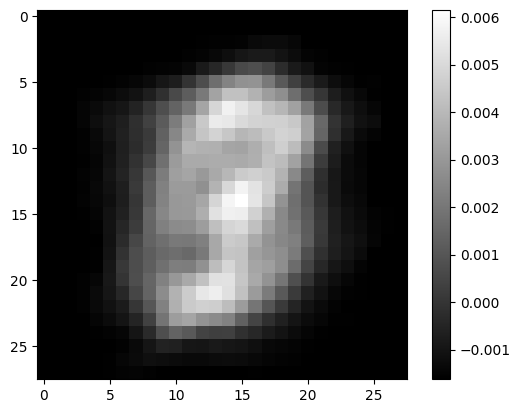

In [4]:
plt.imshow(data.mean(dim=0).reshape(28, 28), cmap="gray")
plt.colorbar()
print(data.mean())

In [5]:
from vectorhash_functions import *

mod_n_positions = []
mod_n_positions_2 = []
mod_n_states = []
mod_n_states_2 = []

# assume shapes are squares

for _ in lambdas:
    mod_n_positions.append(list())
    mod_n_positions_2.append(list())
    mod_n_states.append(list())
    mod_n_states_2.append(list())

for g in g_positions:
    pos = 0
    for i, l in enumerate(lambdas):
        mod_n = g[pos : pos + l**2]
        mod_n_positions[i].append(ConvertToXYNew(mod_n, (l, l)))
        pos += l**2

for g in g_positions2:
    pos = 0
    for i, l in enumerate(lambdas):
        mod_n = g[pos : pos + l**2]
        mod_n_positions_2[i].append(ConvertToXYNew(mod_n, (l, l)))
        pos += l**2

for g in g_points:
    pos = 0
    for i, l in enumerate(lambdas):
        mod_n = g[pos : pos + l**2]
        mod_n_states[i].append(ConvertToXYNew(mod_n, (l, l)))
        pos += l**2

for g in g_points_2:
    pos = 0
    for i, l in enumerate(lambdas):
        mod_n = g[pos : pos + l**2]
        mod_n_states_2[i].append(ConvertToXYNew(mod_n, (l, l)))
        pos += l**2

201
200
201
200


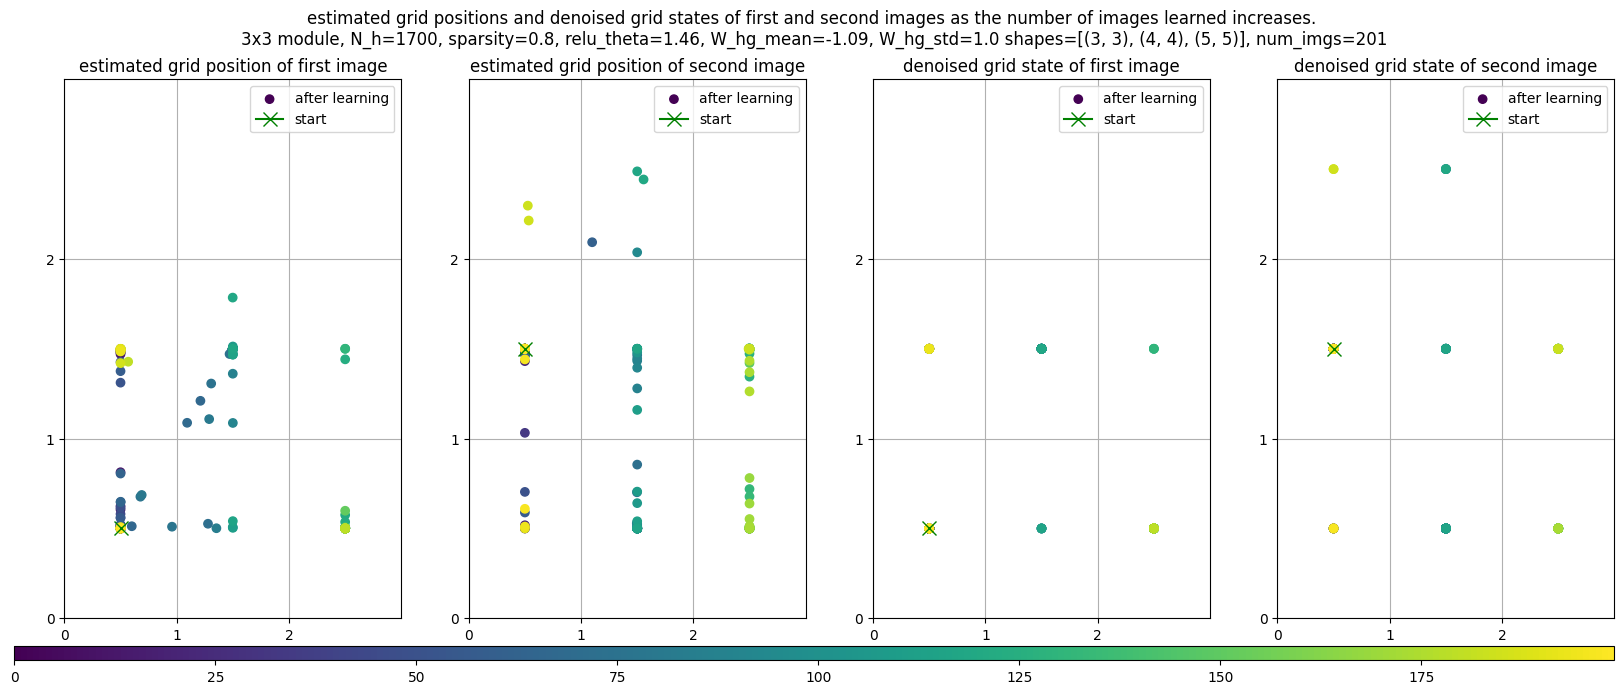

201
200
201
200


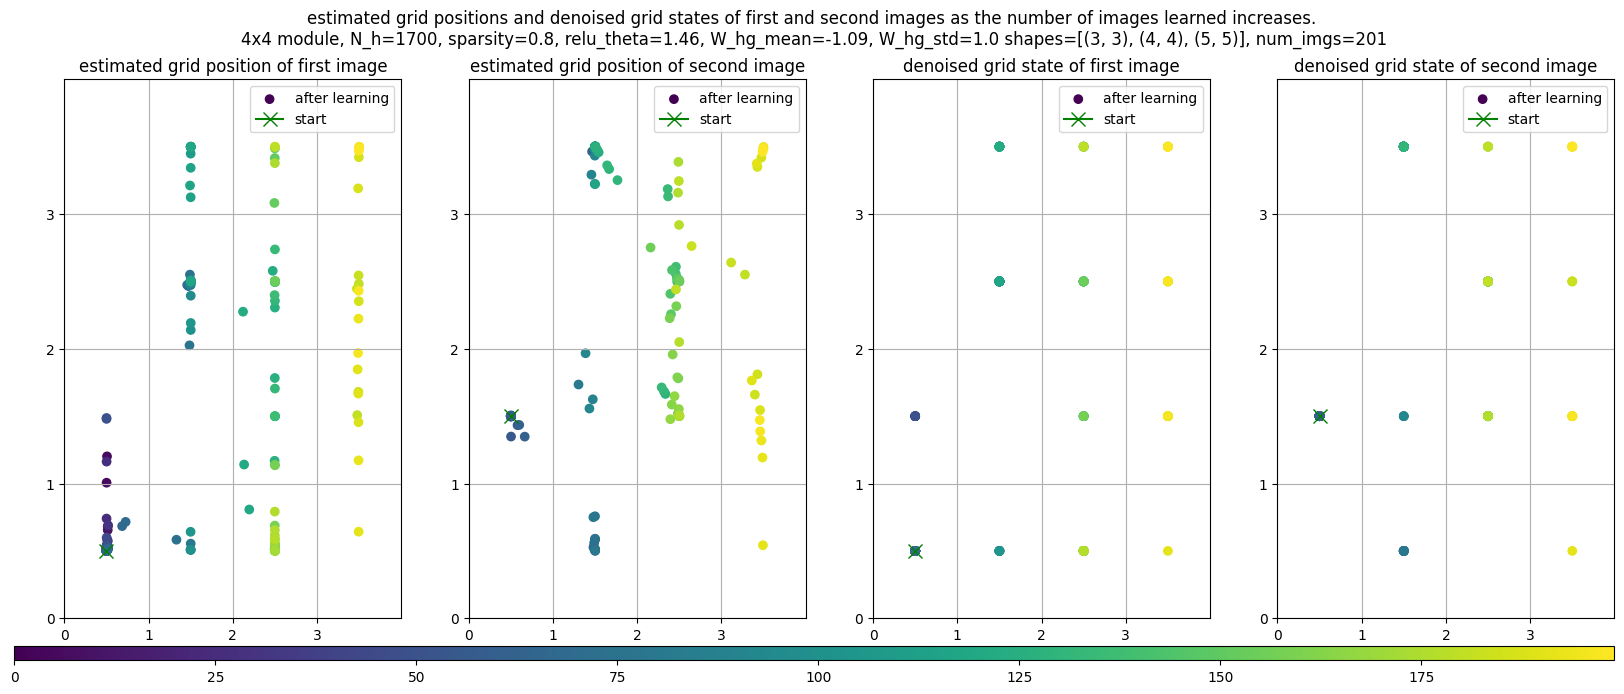

201
200
201
200


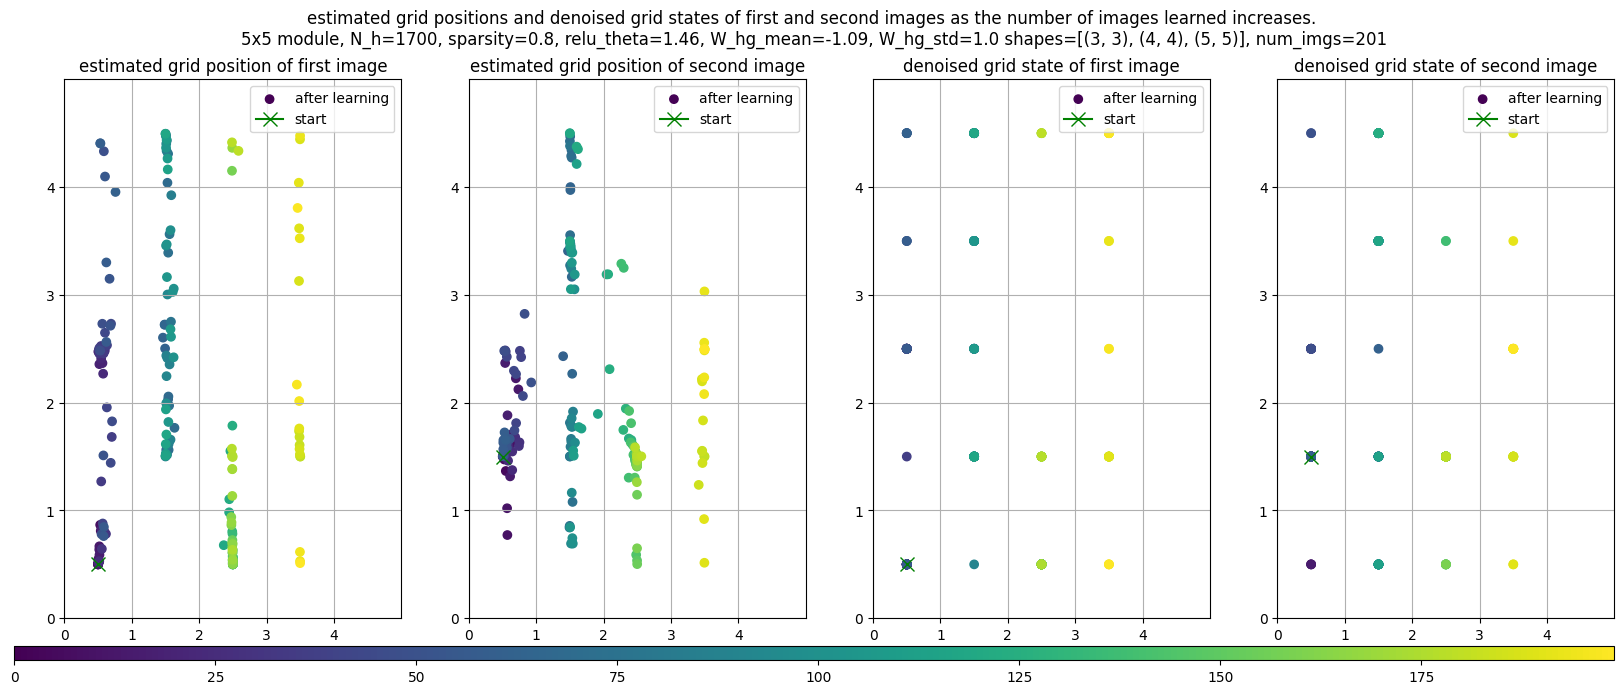

In [6]:
for i, l in enumerate(lambdas):
    GraphGrids(
        shapes_lists=[(l, l), (l, l), (l, l), (l, l)],
        points_lists=[
            mod_n_positions[i],
            mod_n_positions_2[i],
            mod_n_states[i],
            mod_n_states_2[i],
        ],
        first_points=[
            mod_n_positions[i][0],
            mod_n_positions_2[i][0],
            mod_n_states[i][0],
            mod_n_states_2[i][0],
        ],
        titles=[
            f"estimated grid position of first image",
            f"estimated grid position of second image",
            f"denoised grid state of first image",
            f"denoised grid state of second image",
        ],
        main_title=f"estimated grid positions and denoised grid states of first and second images as the number of images learned increases. \n{l}x{l} module, N_h={GS.N_h}, sparsity={round(sparse_initialization, 2)}, relu_theta={round(relu_theta, 2)}, W_hg_mean={round(W_hg_mean, 2)}, W_hg_std={W_hg_std} shapes={shapes}, num_imgs={num_imgs}",
    )

In [7]:
# graph estimated position of each image

In [8]:
print(data.shape)

torch.Size([201, 784])


201
201


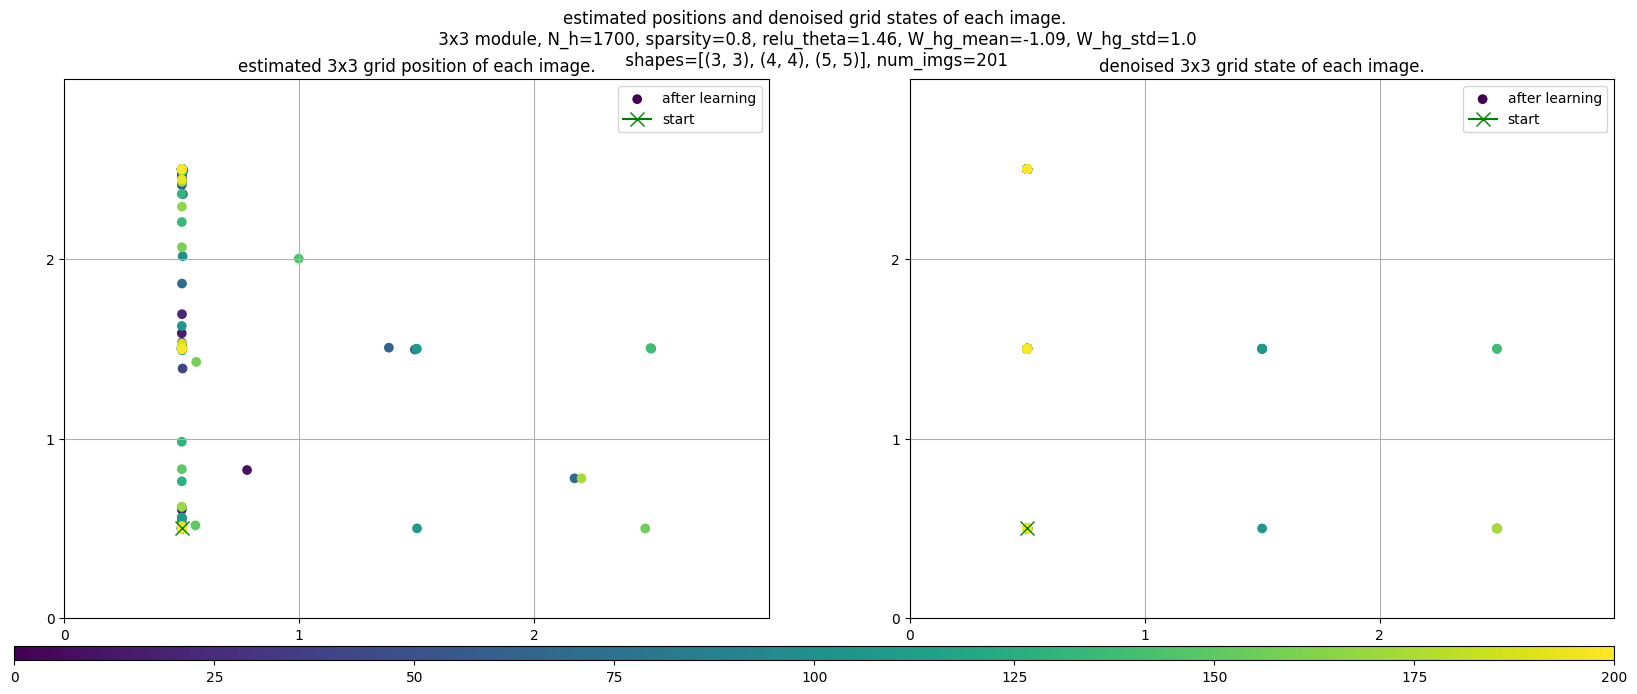

201
201


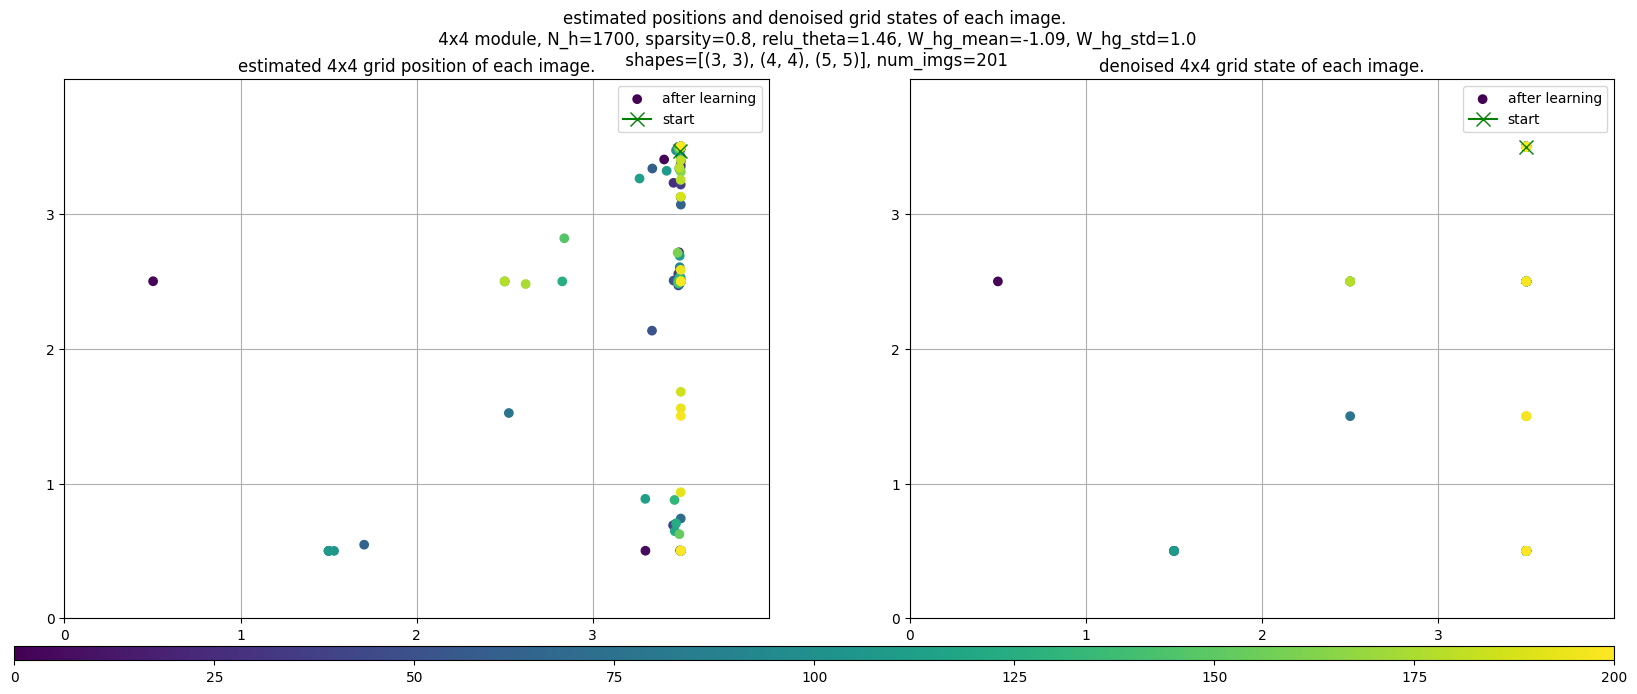

201
201


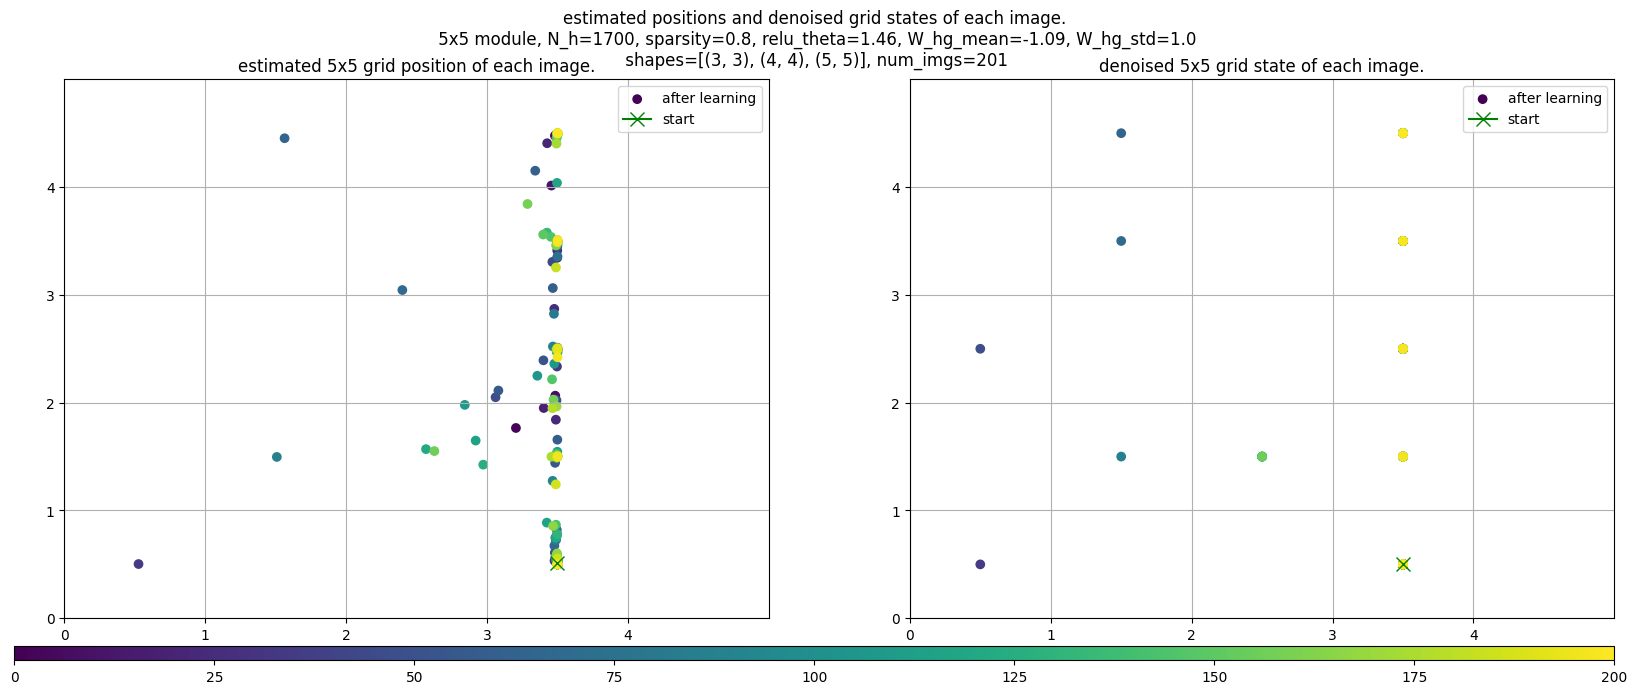

In [9]:
point_positions_n = []
point_states_n = []
for l in lambdas:
    point_positions_n.append([])
    point_states_n.append([])

for img in data:
    pos = GS.estimate_position(img)
    state = GS.denoise(
        GS.grid_from_hippocampal(GS.hippocampal_from_sensory(img))
    ).flatten()

    p = 0
    for i, l in enumerate(lambdas):
        point_positions_n[i].append(ConvertToXYNew(pos[p : p + l**2], (l, l)))
        point_states_n[i].append(ConvertToXYNew(state[p : p + l**2], (l, l)))
        p += l**2

for i, l in enumerate(lambdas):
    GraphGrids(
        shapes_lists=[(l, l), (l, l)],
        points_lists=[point_positions_n[i], point_states_n[i]],
        first_points=[point_positions_n[i][0], point_states_n[i][0]],
        titles=[
            f"estimated {l}x{l} grid position of each image.",
            f"denoised {l}x{l} grid state of each image.",
        ],
        main_title=f"estimated positions and denoised grid states of each image.\n {l}x{l} module, N_h={GS.N_h}, sparsity={round(sparse_initialization, 2)}, relu_theta={round(relu_theta,2 )}, W_hg_mean={round(W_hg_mean, 2)}, W_hg_std={W_hg_std}\n shapes={shapes}, num_imgs={num_imgs}",
    )

Unique Hs seen while recalling: 1
Unique Gs seen while recalling (before denoising): 1
Unique Gs seen while recalling (after denoising): 1
Unique Hs seen while recalling (after denoising): 1
avg nonzero H: 268.0
avg nonzero H_denoised: 94.0
tensor(0.6454)
tensor(1.4255e-11)


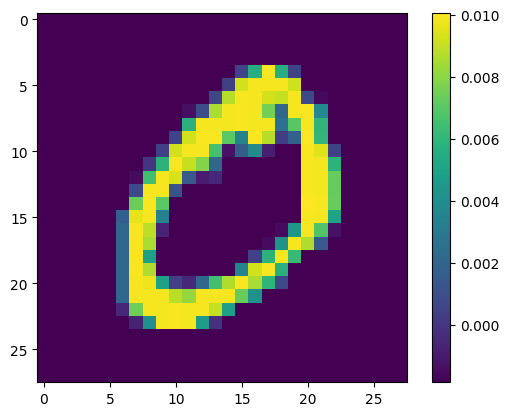

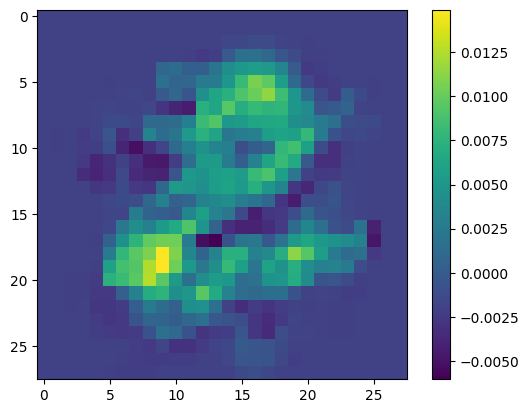

In [10]:
img = data[1]
recalled = GS.recall(img)
print(torch.cosine_similarity(img, recalled, dim=0).mean())

plt.imshow(img.reshape(28,28))
print(img.mean())
plt.colorbar()
plt.show()
plt.imshow((recalled).reshape(28,28))
plt.colorbar()
plt.show()




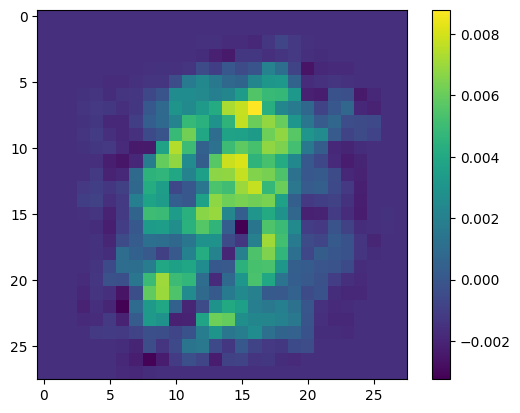

In [11]:
plt.imshow(GS.sensory_from_hippocampal(GS.hippocampal_from_grid(GS.G[3200])).reshape(28,28))
plt.colorbar()
plt.show()

/var/folders/q_/hxdspxw938n3_89qddxh_2fm0000gp/T/ipykernel_10704/154270520.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_by_class = torch.tensor(data).float().to("cpu")


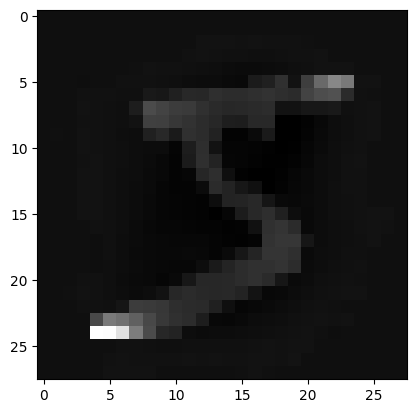

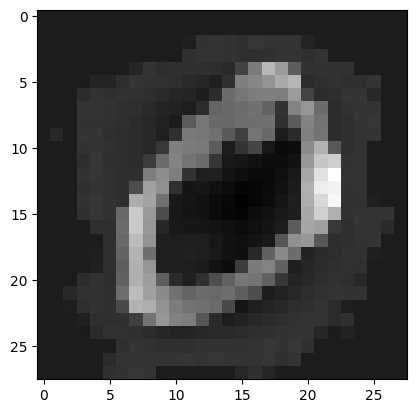

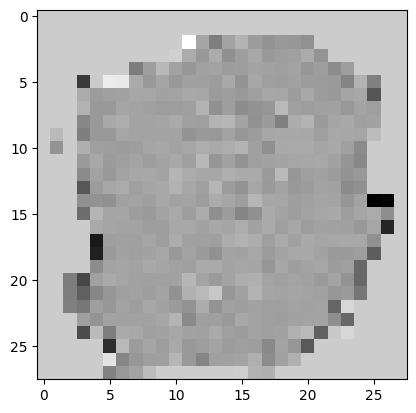

201
201


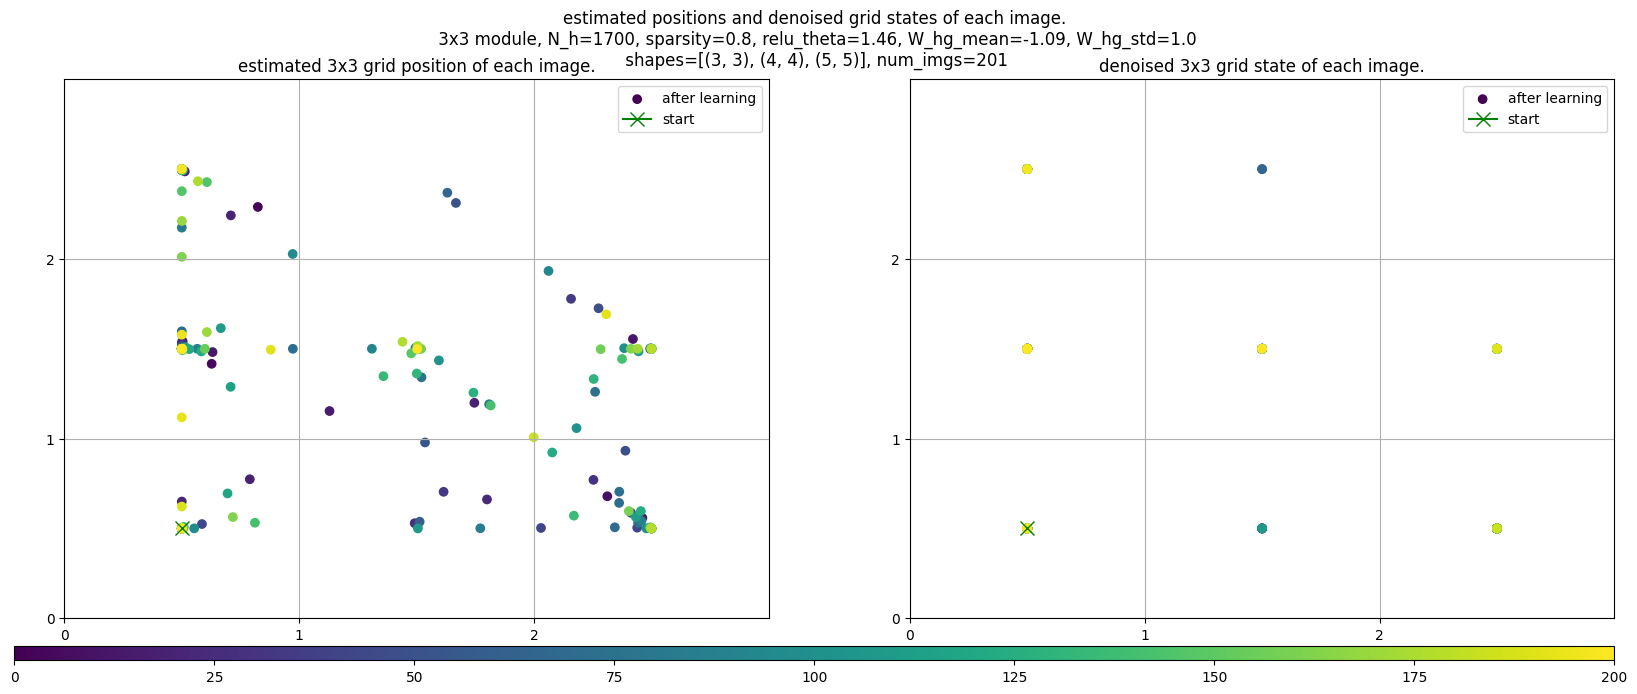

201
201


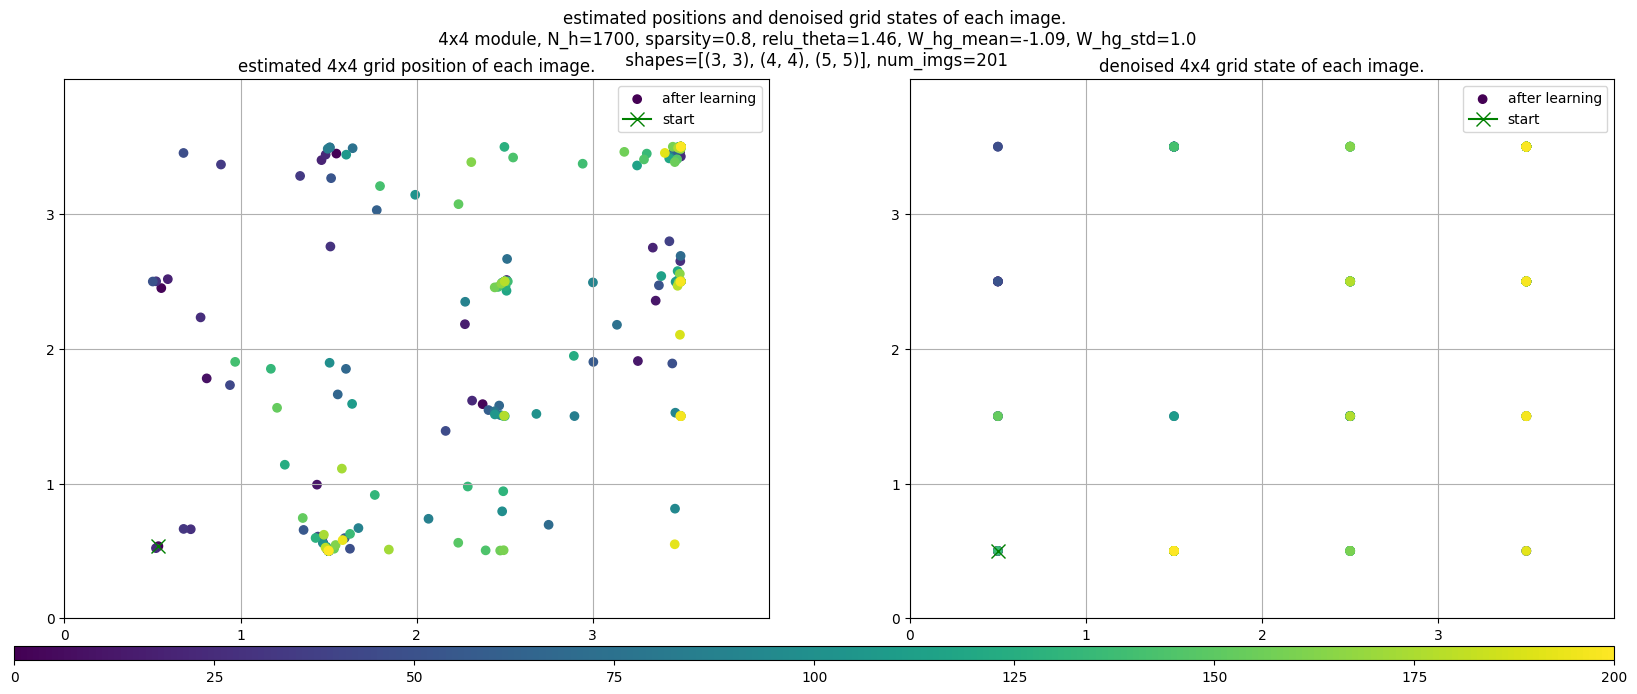

201
201


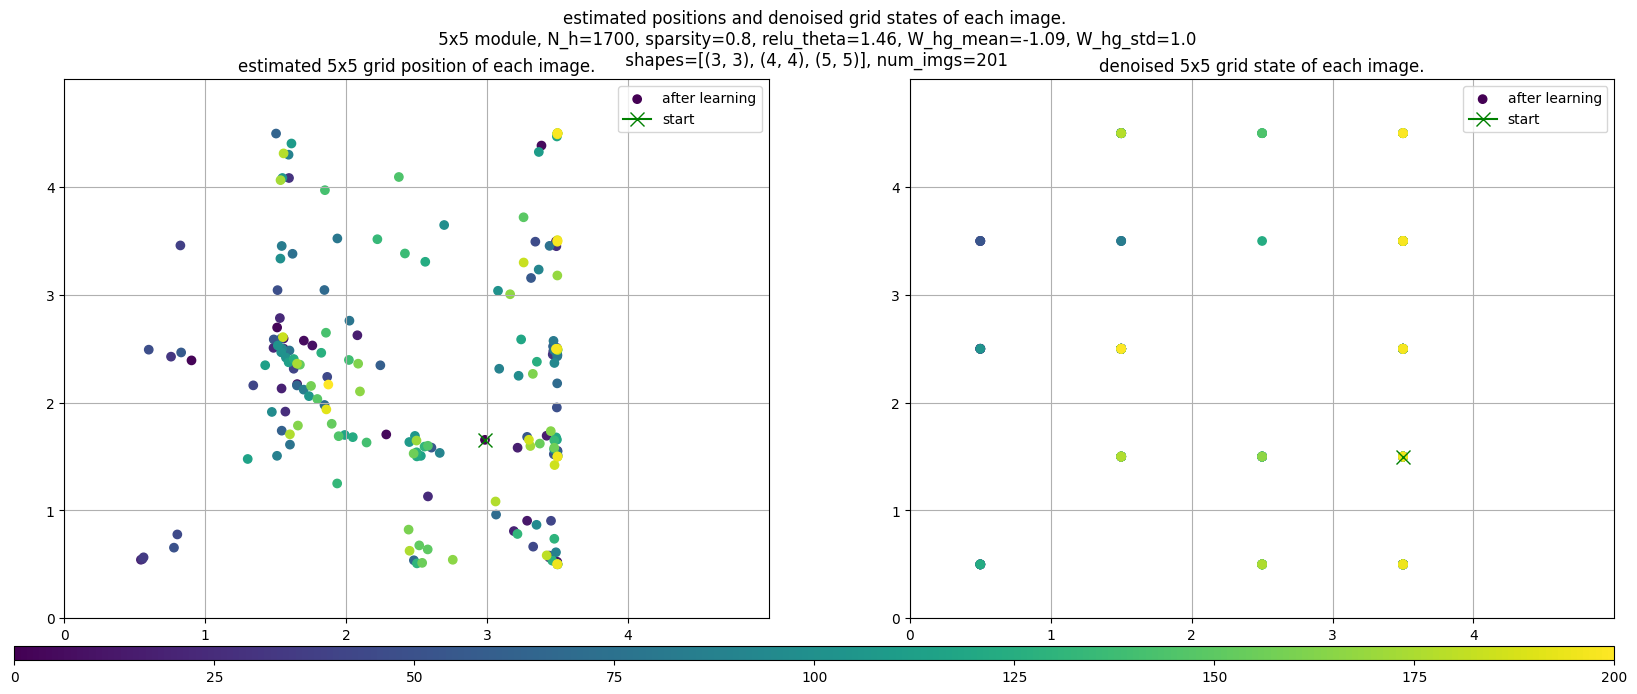

In [12]:
zero_indices = (dataset.train_labels == 0).nonzero().flatten()

data_by_class = dataset.data[zero_indices][:200].reshape(200, 784) 
data_by_class = torch.tensor(data).float().to("cpu")
data_by_class = (data - data.mean(dim=0)) / (data.std(dim=0)+1e-8)

plt.imshow(data_by_class[0].reshape(28, 28), cmap="gray")
plt.show()
plt.imshow(data_by_class[1].reshape(28, 28), cmap="gray")
plt.show()
plt.imshow(data_by_class.mean(dim=0).reshape(28, 28), cmap="gray")
plt.show()

point_positions_n = []
point_states_n = []
for l in lambdas:
    point_positions_n.append([])
    point_states_n.append([])

for img in data_by_class:
    pos = GS.estimate_position(img)
    state = GS.denoise(
        GS.grid_from_hippocampal(GS.hippocampal_from_sensory(img))
    ).flatten()

    p = 0
    for i, l in enumerate(lambdas):
        point_positions_n[i].append(ConvertToXYNew(pos[p : p + l**2], (l, l)))
        point_states_n[i].append(ConvertToXYNew(state[p : p + l**2], (l, l)))
        p += l**2

for i, l in enumerate(lambdas):
    GraphGrids(
        shapes_lists=[(l, l), (l, l)],
        points_lists=[point_positions_n[i], point_states_n[i]],
        first_points=[point_positions_n[i][0], point_states_n[i][0]],
        titles=[
            f"estimated {l}x{l} grid position of each image.",
            f"denoised {l}x{l} grid state of each image.",
        ],
        main_title=f"estimated positions and denoised grid states of each image.\n {l}x{l} module, N_h={GS.N_h}, sparsity={round(sparse_initialization, 2)}, relu_theta={round(relu_theta,2 )}, W_hg_mean={round(W_hg_mean, 2)}, W_hg_std={W_hg_std}\n shapes={shapes}, num_imgs={num_imgs}",
    )